In [1]:
# Get the dataset repository
!git clone https://github.com/codezart/DAA_Dataset.git

Cloning into 'DAA_Dataset'...
remote: Enumerating objects: 67011, done.
remote: Total 67011 (delta 0), reused 0 (delta 0), pack-reused 67011
Receiving objects: 100% (67011/67011), 390.24 MiB | 20.04 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Updating files: 100% (94735/94735), done.


In [2]:
!git clone https://github.com/codezart/Delta_Age_AdaIN.git -b develop

Cloning into 'Delta_Age_AdaIN'...
remote: Enumerating objects: 91491, done.
remote: Counting objects: 100% (24384/24384), done.
remote: Compressing objects: 100% (24108/24108), done.
remote: Total 91491 (delta 304), reused 24348 (delta 273), pack-reused 67107
Receiving objects: 100% (91491/91491), 1.65 GiB | 20.95 MiB/s, done.
Resolving deltas: 100% (336/336), done.


In [3]:
%mv DAA_Dataset/megaage_asian/* Delta_Age_AdaIN/datasets/megaage_asian/

In [4]:
%mv DAA_Dataset/utkface/* Delta_Age_AdaIN/datasets/utkface/

In [5]:
%cd Delta_Age_AdaIN/

/content/Delta_Age_AdaIN


In [6]:
!pip install tensorboardX

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 3.3 MB/s eta 0:00:00


In [ ]:
from datetime import datetime
import logging
import torchvision.transforms as transforms
from types import SimpleNamespace
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
%ls

augmentations.py  constants.py  EMA.py   Networks/    README.md
config.py         datasets/     LICENSE  pipeline.py  train.py


In [ ]:
!git pull

Already up to date.


In [ ]:
import os

class Config:
    def __init__(self):
        # data
        self.datanames = "utkface"
        self.data_folder = "./datasets/"
        self.do_aug = True
        self.num_works = 4

        #utils
        self.model_purpose=""
        self.validation_transformations = [
            transforms.Resize(shape),
            transforms.ToTensor(),

        ]
        self.training_transformations = [
            transforms.Resize(shape),
            transforms.ToTensor(),

        ]
        # train
        self.batch_size = 64
        self.lr = 1e-3
        self.epochs = 120
        self.use_multiple_gpu = False
        self.device_ids = [0, 1] if self.use_multiple_gpu else [0]
        self.pre_epoch = 0
        self.pre_iter = 0
        self.accuracy_threshold = 7
        self.do_multiscale = False
        self.mode = "train" if self.batch_size > 1 else "test"
        # self.save_folder = "/content/gdrive/MyDrive/CV_DAA_PROJ/DAA_models/{}_{}".format(self.model_purpose,self.datanames)

        # net
        self.backbone = "resnet18"  # ['c3ae','resnet18']
        self.input_size = 128  # 96

        self.feat_dim = 32
        self.min_age = 1
        self.max_age = 100
        self.num_classes = self.max_age - self.min_age + 1
        self.da_type = "binary"  # ['binary','decimal', 'image_template']
        self.image_template_path = ""

        self.pretrained_fn = ""
        self.pretrained_ex_params = []

    def save_model_folder(self):
        self.save_folder = "/content/gdrive/MyDrive/CV_DAA_PROJ/DAA_models/{}_{}".format(self.model_purpose,self.datanames)

In [ ]:
import numpy as np
import csv
import math
import random
from tensorboardX import SummaryWriter
import warnings
import logging
warnings.filterwarnings("ignore")
from PIL import Image

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import os
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from Networks.DAANet import DAA
from EMA import EMA
from datasets.data_utils import DataSetFactory
import cv2
import matplotlib.pyplot as plt


class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, name, fmt=":f"):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = "{name} {val" + self.fmt + "} ({avg" + self.fmt + "})"
        return fmtstr.format(**self.__dict__)


class DAATrainer(object):
    def __init__(self, config):
        self.config = config
        self.set_environment()
        self.build_model()
        self.set_train_params()
        self.load_model(self.config.pretrained_fn)
        self.build_data_loader()

        self.train_losses = []
        self.val_losses = []

        self.epoch_train_losses = []
        self.epoch_train_accuracies = []
        self.epoch_val_losses = []
        self.epoch_val_accuracies = []

        self.save_model_dir = "%s_%s_%s_%s" % (
            self.config.save_folder,
            self.config.backbone,
            str(self.config.num_classes),
            self.config.da_type,
        )
        try:
            os.mkdir(self.save_model_dir)
        except:
            pass

        self.summary_writer = SummaryWriter(self.save_model_dir)
        self.syth_losses = AverageMeter("SythnLosses")

    def set_environment(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
        os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
        os.environ["CUDA_VISIBLE_DEVICES"] = ",".join(
            [str(i) for i in self.config.device_ids]
        )

    def set_train_params(self):
        self.init_lr = self.config.lr
        self.lr = self.init_lr
        self.epochs = self.config.epochs
        self.optim = torch.optim.Adam(
            self.model.parameters(), lr=self.lr, weight_decay=1e-3
        )
        self.ema = EMA(self.model, 0.96)
        self.batch_size = self.config.batch_size

    def build_data_loader(self):
        factory = DataSetFactory(self.config)
        self.train_loader = DataLoader(
            factory.training,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.config.num_works,
            drop_last=True,
        )
        self.val_loader = DataLoader(
            factory.testing,
            # batch_size=self.batch_size,
            # shuffle=True,
            # num_workers=self.config.num_works // 2,
            # drop_last=True,
        )
        self.val_iter = iter(self.val_loader)

        if self.config.da_type == "image_template":
            self.template_images = factory.template_images.to(self.device).float()
            self.template_labels = factory.template_labels.to(self.device).float()
            if self.config.use_multiple_gpu:
                self.template_images = self.template_images.repeat(
                    len(self.config.device_ids), 1, 1, 1
                )
                self.template_labels = self.template_labels.repeat(
                    len(self.config.device_ids)
                )

    def build_model(self):
        net_info = {
            "da_type": self.config.da_type,
            "feat_dim": self.config.feat_dim,
            "backbone": self.config.backbone,
            "num_classes": self.config.num_classes,
        }
        self.model = DAA(net_info)
        if self.config.use_multiple_gpu:
            self.model = torch.nn.DataParallel(self.model)
        self.model = self.model.to(self.device)

    def load_model(self, model_fn):
        if model_fn == "":
            return
        t = torch.cuda.is_available()
        state_dict = (
            torch.load(model_fn)
            if t
            else torch.load(model_fn, map_location=lambda storage, loc: storage)
        )
        try:
            self.optim.load_state_dict(state_dict["optimizer"])
            self.model.load_state_dict(state_dict["net"])
            return
        except:
            pass
        state_dict = state_dict["net"]
        model_dict = self.model.state_dict()

        for k, v in state_dict.items():
            #    model_dict[k] = model_dict[k].to(self.device)
            print(k, v.shape)
        ex_list = self.config.pretrained_ex_params

        def ex_fun(k):
            for ex in ex_list:
                if ex in k:
                    return False
            return True

        predict = "module." if self.config.use_multiple_gpu else ""
        pretrained_dict = {
            k if "module" in k else predict + k: v
            for k, v in state_dict.items()
            if ex_fun(k)
        }
        model_dict.update(pretrained_dict)

        self.model.load_state_dict(model_dict, strict=True)
        print("The model in path %s has been loaded successfully!" % model_fn)
        logging.info("The model in path %s has been loaded successfully!" % model_fn)

    def save_model(self, epoch):
        self.ema.apply_shadow()
        state = {"net": self.model.state_dict(), "optimizer": self.optim.state_dict()}
        save_fn = "%s/%s_%s_epoch_%d_ac_%s.pth" % (
            self.save_model_dir,
            self.config.model_purpose,
            self.config.backbone,
            epoch,
            self.accuracy_info,
        )
        torch.save(state, save_fn)
        self.ema.restore()
        print(
            "The model of the %d epoch is successfully stored in path %s!"
            % (epoch, save_fn)
        )
        logging.info(
            "The model of the %d epoch is successfully stored in path %s!"
            % (epoch, save_fn)
        )

    def adjust_learning_rate(self, optimizer):
        """Sets the learning rate to the initial LR decayed by 2 every 10 epochs after 20 epoches"""
        self.lr = (
            max(
                self.init_lr * (1.0 + np.cos(self.step * np.pi / self.max_iter_step)),
                2e-6,
            )
            * 0.5
        )
        for param_group in optimizer.param_groups:
            param_group["lr"] = self.lr

    def get_val_batch(self):
        try:
            images, labels = next(self.val_iter)
        except:
            self.val_iter = iter(self.val_loader)
            images, labels = next(self.val_iter)
            pass
        return [images, labels]

    def write_summary(self):
        k = 1
        self.summary_writer.add_scalar("train/lr", self.lr, self.step)
        if True:
            for key, value in self.summary_image.items():
                self.summary_writer.add_images("{}".format(key), value[:k], self.step)

            for key, value in self.summary_loss.items():
                self.summary_writer.add_scalar("{}".format(key), value, self.step)

            for key, value in self.summary_histogram.items():
                self.summary_writer.add_histogram(
                    "{}".format(key), value[:k], self.step
                )
        # except:
        #    pass

    def train(self):
        pre_epoch = self.config.pre_epoch
        self.max_iter_step = len(self.train_loader) * self.epochs
        self.step = self.config.pre_iter  # 19890#pre_epoch*len(self.train_loader)/2

        print(
            "train begin,total step is %d, total epochs is %d"
            % (self.max_iter_step - self.step, self.epochs - pre_epoch)
        )
        logging.info(
            "train begin,total step is %d, total epochs is %d"
            % (self.max_iter_step - self.step, self.epochs - pre_epoch)
        )
        for epoch in range(pre_epoch, self.epochs + 1):
            self.train_epoch(epoch)
            if epoch % 5 == 0:
                self.save_model(epoch)

    def run(self, images, labels, mode="train"):
        images = images.to(self.device)
        for key, value in labels.items():
            labels[key] = value.to(self.device)

        run_info = {}

        run_info["labels"] = labels["gt_age"]
        run_info["mode"] = mode
        run_info["accuracy_threshold"] = self.config.accuracy_threshold
        if self.config.da_type == "image_template":
            run_info["template_images"] = self.template_images
            run_info["template_labels"] = self.template_labels

        outputs = self.model(images, run_info)
        if mode.lower() != "test":
            for k, v in outputs["loss"].items():
                self.summary_loss["{}/{}".format(mode, k)] = v
            self.summary_image["{}/image".format(mode)] = images[0:1]
        return outputs

    def train_epoch(self, epoch):
        self.model.train()
        self.summary_loss = {}
        self.summary_image = {}
        self.summary_histogram = {}
        # Initialize accumulators for losses and accuracies
        total_train_loss = 0
        total_train_accuracy = 0
        train_batches = 0

        print("current epoch is %d, learning_rate: %s" % (epoch, str(self.lr)))
        logging.info("current epoch is %d, learning_rate: %s" % (epoch, str(self.lr)))
        for n, (images, labels) in enumerate(self.train_loader):
            self.step = self.step + 1
            self.adjust_learning_rate(self.optim)

            self.summary_loss = {}
            self.summary_image = {}
            self.summary_histogram = {}

            train_outputs = self.run(images, labels, mode="train")
            train_loss = train_outputs["loss"]["total_loss"]
            train_accuracy = train_outputs["loss"]["accuracy"]

            self.total_loss = train_outputs["loss"]["total_loss"]
            # self.train_losses.append(self.total_loss.item())

            self.optim.zero_grad()
            self.total_loss.backward()
            self.optim.step()
            self.ema.update_params()

            # self.syth_losses.update(self.total_loss.detach().item(), images.shape[0])
            # self.summary_loss["train/avg_loss"] = self.syth_losses.avg

            # Update training metrics
            total_train_loss += train_loss.item()
            total_train_accuracy += train_accuracy.item()
            train_batches += 1

            if n % 50 == 0:
                with torch.no_grad():
                    x_val, y_val = self.get_val_batch()
                    self.model.eval()
                    self.ema.apply_shadow()

                    # Initialize accumulators for validation metrics
                    total_val_loss = 0
                    total_val_accuracy = 0
                    val_batches = 0

                    for x_val, y_val in self.val_loader:
                        val_outputs = self.run(x_val, y_val, "val")
                        val_loss = val_outputs["loss"]["total_loss"]
                        val_accuracy = val_outputs["loss"]["accuracy"]  # Assuming accuracy is part of val_outputs

                        total_val_loss += val_loss.item()
                        total_val_accuracy += val_accuracy.item()
                        val_batches += 1

                    self.ema.restore()
                    self.model.train()

                    # Calculate average validation metrics for this checkpoint
                    avg_val_loss = total_val_loss / val_batches if val_batches > 0 else 0
                    avg_val_accuracy = total_val_accuracy / val_batches if val_batches > 0 else 0

                    print(
                        f"Validation - Epoch: {epoch}, Loss: {avg_val_loss:.4f}, Accuracy: {avg_val_accuracy:.4f}"
                    )
                    logging.info(
                        f"Validation - Epoch: {epoch}, Loss: {avg_val_loss:.4f}, Accuracy: {avg_val_accuracy:.4f}"
                    )
        # Calculate average training metrics for the epoch
        avg_train_loss = total_train_loss / train_batches if train_batches > 0 else 0
        avg_train_accuracy = total_train_accuracy / train_batches if train_batches > 0 else 0

        # Store the average metrics for the epoch
        self.epoch_train_losses.append(avg_train_loss)
        self.epoch_train_accuracies.append(avg_train_accuracy)

        # Assuming you want to also capture the last validation metrics of the epoch
        self.epoch_val_losses.append(avg_val_loss)
        self.epoch_val_accuracies.append(avg_val_accuracy)
        train_accuracy_age = train_outputs["loss"]["accuracy"].item()
        val_accuracy_age = val_outputs["loss"]["accuracy"].item()

        self.accuracy_info = "%.2f-%.2f" % (
            train_accuracy_age,
            val_accuracy_age,
        )

        print(
            f"Training - Epoch: {epoch}, Loss: {avg_train_loss:.4f}, Accuracy: {avg_train_accuracy:.4f}"
        )
        logging.info(f"Training - Epoch: {epoch}, Loss: {avg_train_loss:.4f}, Accuracy: {avg_train_accuracy:.4f}")
                    # val_outputs = self.run(x_val, y_val, "val")
                    # self.ema.restore()
                    # self.model.train()
                    # self.write_summary()

                    # val_loss = val_outputs["loss"]["total_loss"].item()
                    # self.val_losses.append(val_loss)

                    # print(
                    #     "epoch:{},iter:{},total_loss:{},train/val: {}".format(
                    #         epoch,
                    #         self.step,
                    #         self.total_loss.detach().cpu(),
                    #         self.accuracy_info,
                    #     )
                    # )

            # del train_outputs, self.total_loss

    def test(self):
        self.model.eval()
        cnt, sum_diff = 0, 0
        acc = [0, 0, 0, 0]
        acc_th = [1, 3, 5, 7]
        l1_losses = []
        message = "total samples:", len(self.val_loader)
        print(message)
        logging.info(message)

        for n, (x_val, y_val) in enumerate(self.val_loader):
            output = self.run(x_val, y_val, "test")
            diff = output["l1"].detach().cpu().item()  # Assuming this is the absolute difference
            l1_losses.append(diff)
            for c in range(len(acc)):
                acc[c] = acc[c] + (1.0 if diff <= acc_th[c] else 0.0)

            sum_diff += diff
            cnt += 1

            if cnt % 1000 == 0:
                print(cnt, sum_diff / cnt, acc)
                logging.info(cnt, sum_diff / cnt, acc)

        # Calculate Mean Absolute Error
        mae = sum_diff / cnt
        print(f"MAE: {mae}")
        logging.info(f"MAE: {mae}")

        msg = ["ca{}:{}".format(acc_th[i], acc[i] / cnt) for i in range(len(acc))]
        print(msg)
        logging.info(msg)

        return mae, l1_losses


In [ ]:
shape=(128,128)

In [ ]:
%ls /content/

DAA_Dataset/  Delta_Age_AdaIN/  gdrive/  sample_data/


In [ ]:
# load dataset
# get metrics
import pandas as pd
import matplotlib.pyplot as plt

megaage_asian = "/content/Delta_Age_AdaIN/datasets/megaage_asian/megaage_asian.csv"
utkface = "/content/Delta_Age_AdaIN/datasets/utkface/utkface.csv"


# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(utkface)  # Replace 'your_file.csv' with the actual file path
# df = df[df['age'] > 5]

# max_rows_per_age = 800

# Function to sample rows
def sample_rows(group):
    return group.sample(n=min(len(group), max_rows_per_age))

# Group by age and apply the sampling function
df = df.groupby('age').apply(sample_rows).reset_index(drop=True)

# Basic statistics
summary_stats = df.describe()

# Count of unique values in 'type' column
type_counts = df['type'].value_counts()

# Group the data by 'age' and count the occurrences
age_counts = df['age'].value_counts()

# Display the number of images per age
print("Number of Images per Age:")
print(age_counts)

# Histogram of 'age' column
plt.figure(figsize=(8, 6))
plt.hist(df['age'], bins=20, edgecolor='k')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution')
plt.show()

# Pie chart of 'type' column
plt.figure(figsize=(8, 6))
plt.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Data Type Distribution')
plt.show()

# Scatter plot of 'age' vs 'type'
plt.figure(figsize=(8, 6))
plt.scatter(df['age'], df['type'])
plt.xlabel('Age')
plt.ylabel('Type')
plt.title('Age vs Type')
plt.show()

# Box plot of 'age' by 'type'
plt.figure(figsize=(8, 6))
df.boxplot(column='age', by='type')
plt.title('Box Plot of Age by Type')
plt.suptitle('')  # Remove default title
plt.xlabel('Type')
plt.ylabel('Age')
plt.show()

# Additional statistics and plots can be generated based on your specific needs

# Display the summary statistics
print("Summary Statistics:")
print(summary_stats)

# Display the count of unique values in 'type' column
print("\nType Counts:")
print(type_counts)



NameError: ignored

Number of Images per Age:
1     1885
28    1691
24    1367
27    1321
23    1146
      ... 
68     207
69     194
59     169
62     160
63     108
Name: age, Length: 70, dtype: int64


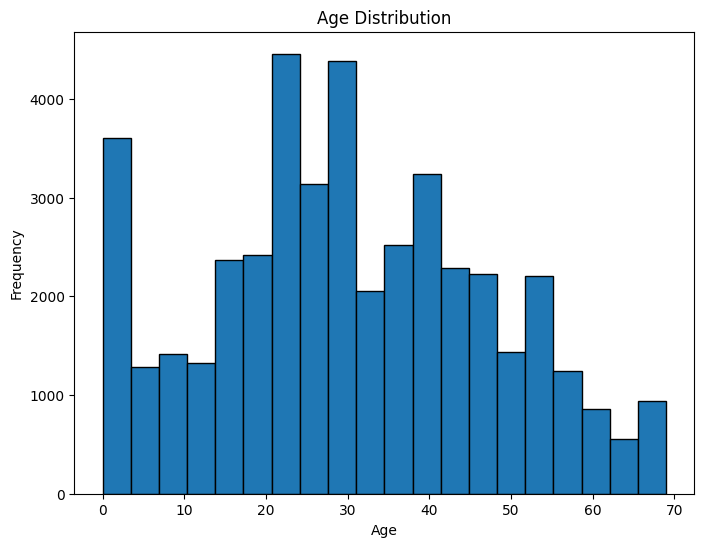

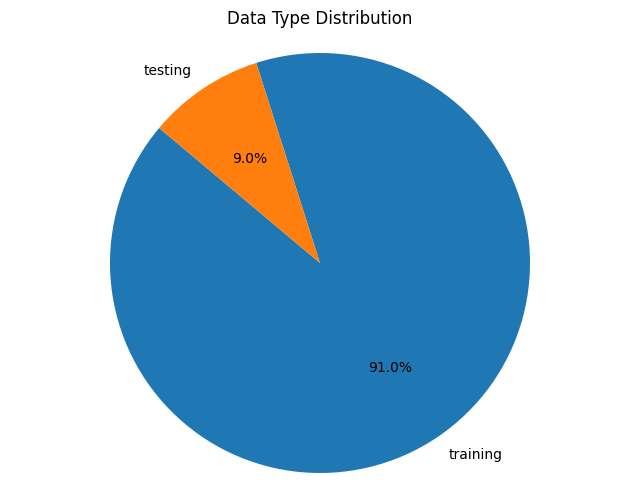

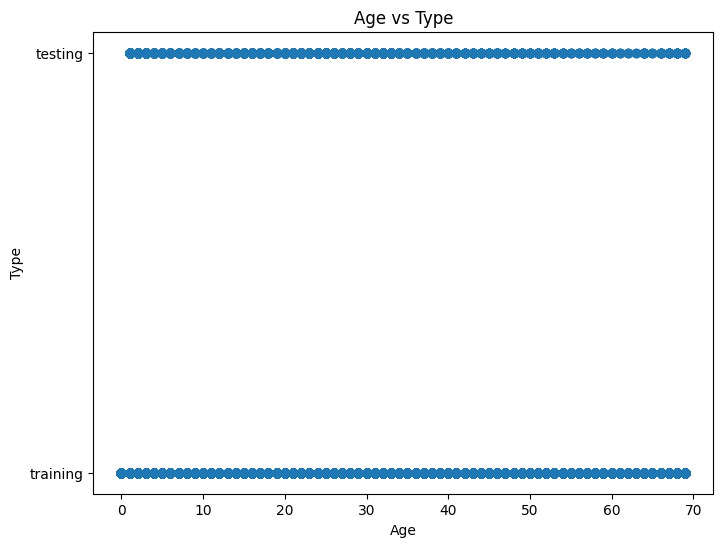

<Figure size 800x600 with 0 Axes>

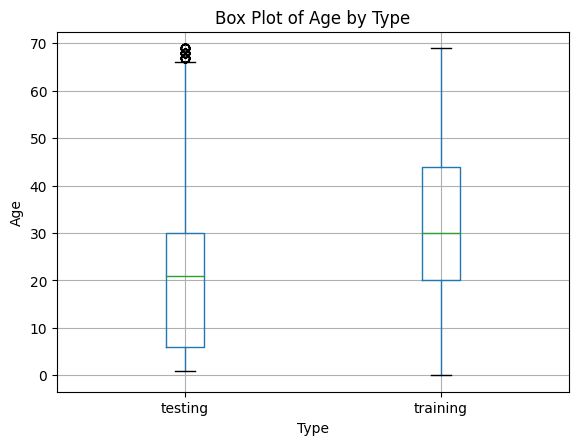

Summary Statistics:
                age
count  43945.000000
mean      30.308340
std       17.009113
min        0.000000
25%       19.000000
50%       29.000000
75%       43.000000
max       69.000000

Type Counts:
training    40000
testing      3945
Name: type, dtype: int64


In [ ]:
# load dataset
# get metrics
import pandas as pd
import matplotlib.pyplot as plt

megaage_asian = "/content/Delta_Age_AdaIN/datasets/megaage_asian/megaage_asian.csv"
utkface = "/content/Delta_Age_AdaIN/datasets/utkface/utkface.csv"


# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(megaage_asian)  # Replace 'your_file.csv' with the actual file path

# Basic statistics
summary_stats = df.describe()

# Count of unique values in 'type' column
type_counts = df['type'].value_counts()

# Group the data by 'age' and count the occurrences
age_counts = df['age'].value_counts()

# Display the number of images per age
print("Number of Images per Age:")
print(age_counts)

# Histogram of 'age' column
plt.figure(figsize=(8, 6))
plt.hist(df['age'], bins=20, edgecolor='k')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution')
plt.show()

# Pie chart of 'type' column
plt.figure(figsize=(8, 6))
plt.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Data Type Distribution')
plt.show()

# Scatter plot of 'age' vs 'type'
plt.figure(figsize=(8, 6))
plt.scatter(df['age'], df['type'])
plt.xlabel('Age')
plt.ylabel('Type')
plt.title('Age vs Type')
plt.show()

# Box plot of 'age' by 'type'
plt.figure(figsize=(8, 6))
df.boxplot(column='age', by='type')
plt.title('Box Plot of Age by Type')
plt.suptitle('')  # Remove default title
plt.xlabel('Type')
plt.ylabel('Age')
plt.show()

# Additional statistics and plots can be generated based on your specific needs

# Display the summary statistics
print("Summary Statistics:")
print(summary_stats)

# Display the count of unique values in 'type' column
print("\nType Counts:")
print(type_counts)



In [ ]:
project_dir = "/content/gdrive/MyDrive/CV_DAA_PROJ/DAA_models/"


In [ ]:
models_noaug = [
    {
      "model_purpose":"transferlearned_no_augmentation_VF_30epoch",
      "dataset":"utkface",
      "model_path":"transferlearned_no_augmentation_VF_30epoch_utkface_resnet18_100_binary/transferlearned_no_augmentation_VF_30epoch_resnet18_epoch_20_ac_85.94-67.19.pth",
    },
    {
      "model_purpose":"transferlearned_no_augmentation_VF_30epoch",
      "dataset":"utkface",
      "model_path":"transferlearned_no_augmentation_VF_30epoch_utkface_resnet18_100_binary/transferlearned_no_augmentation_VF_30epoch_resnet18_epoch_15_ac_81.25-65.62.pth",
    },

    {
      "model_purpose":"transferlearned_no_augmentation_VF_30epoch",
      "dataset":"utkface",
      "model_path":"transferlearned_no_augmentation_VF_30epoch_utkface_resnet18_100_binary/transferlearned_no_augmentation_VF_30epoch_resnet18_epoch_10_ac_67.19-57.81.pth",
    },
    {
      "model_purpose":"transferlearned_no_augmentation_VF_30epoch",
      "dataset":"utkface",
      "model_path":"transferlearned_no_augmentation_VF_30epoch_utkface_resnet18_100_binary/transferlearned_no_augmentation_VF_30epoch_resnet18_epoch_5_ac_78.12-57.81.pth",
    },
]


In [ ]:

# For the following models go through the test pipeline
def plot_test_l1_losses(trainer,l1_losses):
    interval = 10
    avg_l1_losses = [sum(l1_losses[i:i+interval])/interval for i in range(0, len(l1_losses), interval)]
    plt.figure(figsize=(10, 5))
    plt.plot(avg_l1_losses)
    plt.title('Average L1 Loss per Interval')
    plt.xlabel('Interval')
    plt.ylabel('Average L1 Loss')
    plt.savefig(f'{trainer.save_model_dir}/test_l1_loss_{datetime.now().strftime("%m-%d_%H")}.png')

def test_models(models):
  for model in models:
      model_path = os.path.join(project_dir, model["model_path"])

      config = Config()
      config.pretrained_fn = model_path
      config.datanames = model["dataset"]
      config.save_model_folder()

      # start testing with test data
      trainer = DAATrainer(config)
      mae, l1_losses = trainer.test()

      # plot graphs
      plot_test_l1_losses(trainer,l1_losses)

firstconv is 3x3
Age 0: 0
Age 1: 0
Age 2: 0
Age 3: 0
Age 4: 0
Age 5: 0
Age 6: 129
Age 7: 243
Age 8: 154
Age 9: 141
Age 10: 60
Age 11: 112
Age 12: 79
Age 13: 145
Age 14: 163
Age 15: 217
Age 16: 137
Age 17: 230
Age 18: 89
Age 19: 254
Age 20: 316
Age 21: 364
Age 22: 376
Age 23: 779
Age 24: 645
Age 25: 800
Age 26: 552
Age 27: 800
Age 28: 510
Age 29: 641
Age 30: 328
Age 31: 602
Age 32: 124
Age 33: 367
Age 34: 785
Age 35: 430
Age 36: 276
Age 37: 288
Age 38: 243
Age 39: 464
Age 40: 117
Age 41: 244
Age 42: 141
Age 43: 91
Age 44: 398
Age 45: 135
Age 46: 161
Age 47: 144
Age 48: 126
Age 49: 335
Age 50: 121
Age 51: 210
Age 52: 219
Age 53: 329
Age 54: 240
Age 55: 223
Age 56: 90
Age 57: 251
Age 58: 72
Age 59: 262
Age 60: 137
Age 61: 116
Age 62: 91
Age 63: 46
Age 64: 226
Age 65: 70
Age 66: 83
Age 67: 91
Age 68: 48
Age 69: 133
Age 70: 29
Age 71: 88
Age 72: 57
Age 73: 28
Age 74: 140
Age 75: 55
Age 76: 25
Age 77: 64
Age 78: 20
Age 79: 124
Age 80: 22
Age 81: 37
Age 82: 16
Age 83: 22
Age 84: 146
Age 85: 3

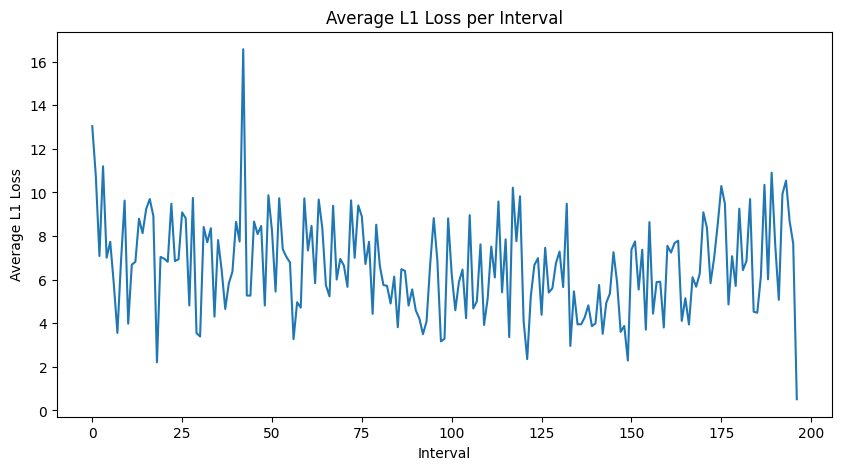

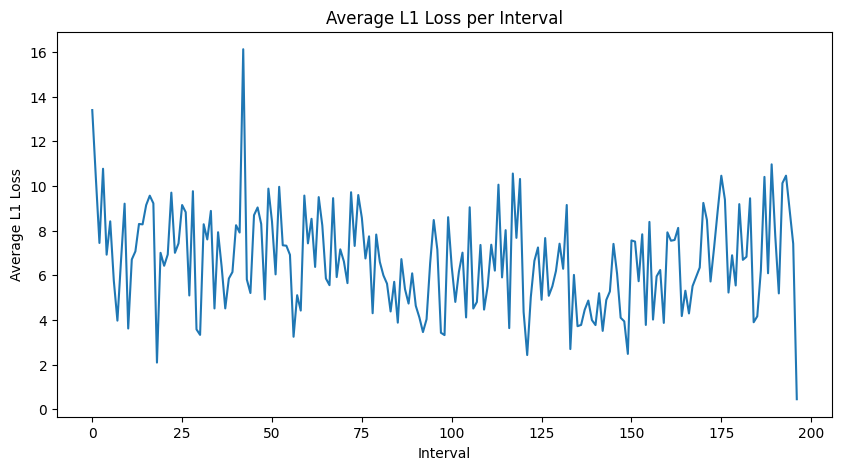

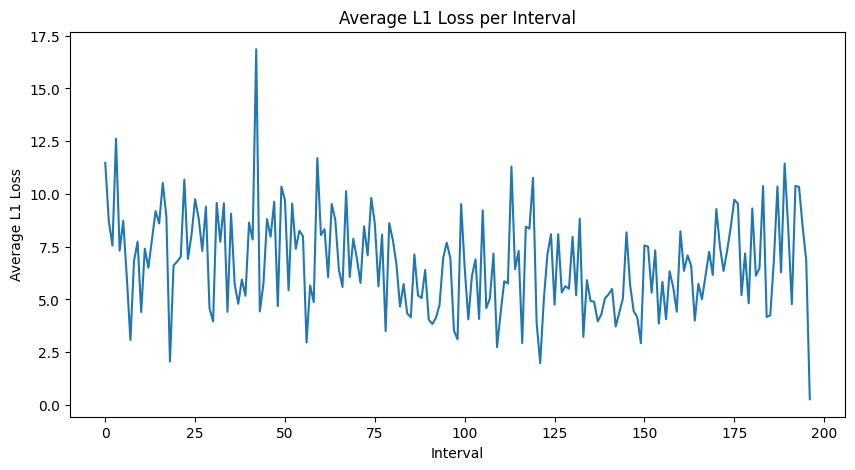

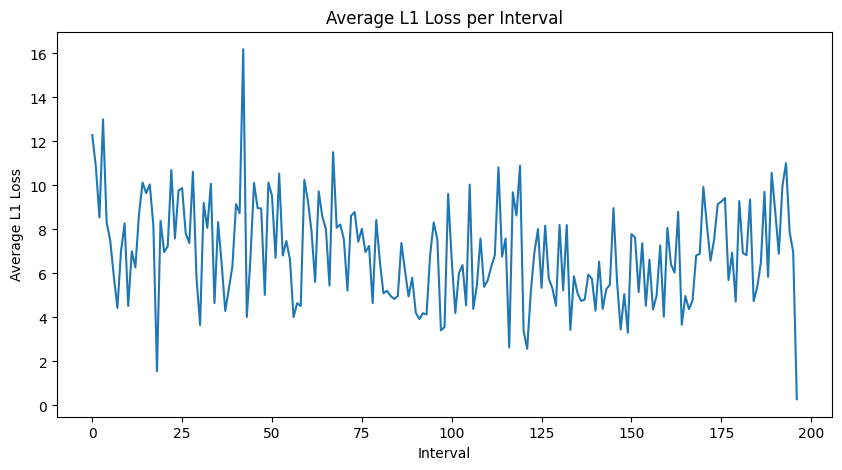

In [ ]:
test_models(models_noaug)

In [ ]:
models_colorbased = [
    {
      "model_purpose":"transferlearned_no_augmentation_VF_30epoch",
      "dataset":"utkface",
      "model_path":"transferlearned_color_based_aug_VF_30epoch_utkface_resnet18_100_binary/transferlearned_color_based_aug_VF_30epoch_resnet18_epoch_5_ac_71.88-76.56.pth",
    },
    {
      "model_purpose":"transferlearned_no_augmentation_VF_30epoch",
      "dataset":"utkface",
      "model_path":"transferlearned_color_based_aug_VF_30epoch_utkface_resnet18_100_binary/transferlearned_color_based_aug_VF_30epoch_resnet18_epoch_10_ac_67.19-67.19.pth",
    },

    {
      "model_purpose":"transferlearned_no_augmentation_VF_30epoch",
      "dataset":"utkface",
      "model_path":"transferlearned_color_based_aug_VF_30epoch_utkface_resnet18_100_binary/transferlearned_color_based_aug_VF_30epoch_resnet18_epoch_15_ac_75.00-64.06.pth"
    },
    {
      "model_purpose":"transferlearned_no_augmentation_VF_30epoch",
      "dataset":"utkface",
      "model_path": "transferlearned_color_based_aug_VF_30epoch_utkface_resnet18_100_binary/transferlearned_color_based_aug_VF_30epoch_resnet18_epoch_20_ac_82.81-60.94.pth"
    },
]



firstconv is 3x3
Age 0: 0
Age 1: 0
Age 2: 0
Age 3: 0
Age 4: 0
Age 5: 0
Age 6: 129
Age 7: 243
Age 8: 154
Age 9: 141
Age 10: 60
Age 11: 112
Age 12: 79
Age 13: 145
Age 14: 163
Age 15: 217
Age 16: 137
Age 17: 230
Age 18: 89
Age 19: 254
Age 20: 316
Age 21: 364
Age 22: 376
Age 23: 779
Age 24: 645
Age 25: 800
Age 26: 552
Age 27: 800
Age 28: 510
Age 29: 641
Age 30: 328
Age 31: 602
Age 32: 124
Age 33: 367
Age 34: 785
Age 35: 430
Age 36: 276
Age 37: 288
Age 38: 243
Age 39: 464
Age 40: 117
Age 41: 244
Age 42: 141
Age 43: 91
Age 44: 398
Age 45: 135
Age 46: 161
Age 47: 144
Age 48: 126
Age 49: 335
Age 50: 121
Age 51: 210
Age 52: 219
Age 53: 329
Age 54: 240
Age 55: 223
Age 56: 90
Age 57: 251
Age 58: 72
Age 59: 262
Age 60: 137
Age 61: 116
Age 62: 91
Age 63: 46
Age 64: 226
Age 65: 70
Age 66: 83
Age 67: 91
Age 68: 48
Age 69: 133
Age 70: 29
Age 71: 88
Age 72: 57
Age 73: 28
Age 74: 140
Age 75: 55
Age 76: 25
Age 77: 64
Age 78: 20
Age 79: 124
Age 80: 22
Age 81: 37
Age 82: 16
Age 83: 22
Age 84: 146
Age 85: 3

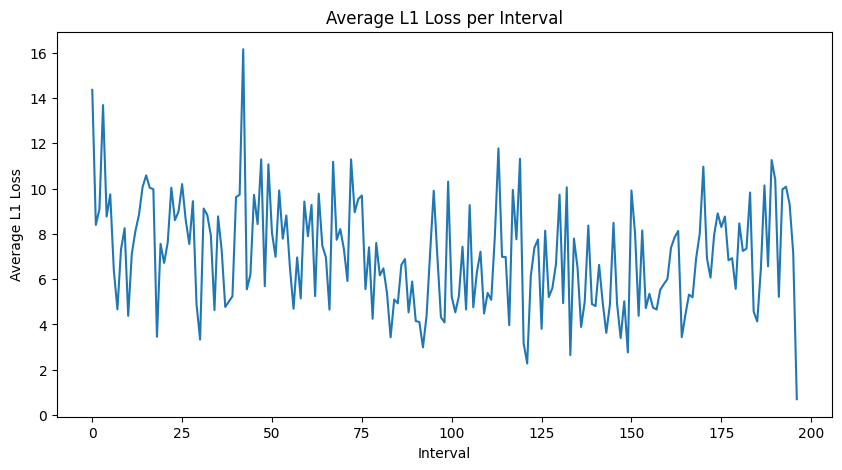

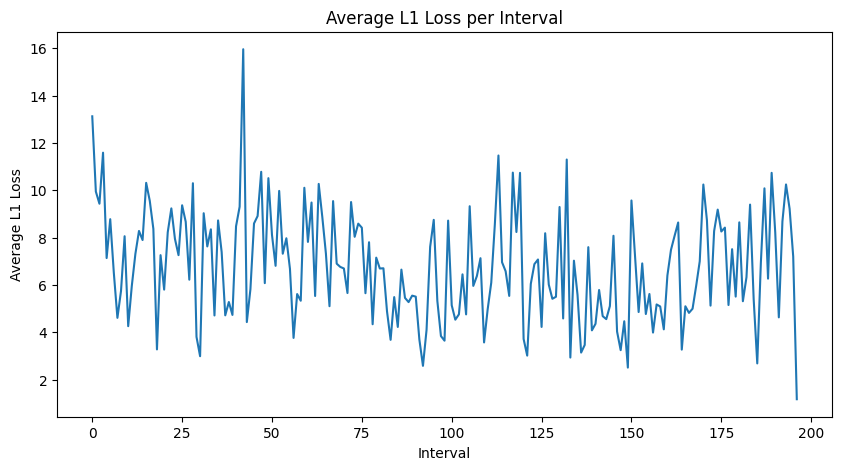

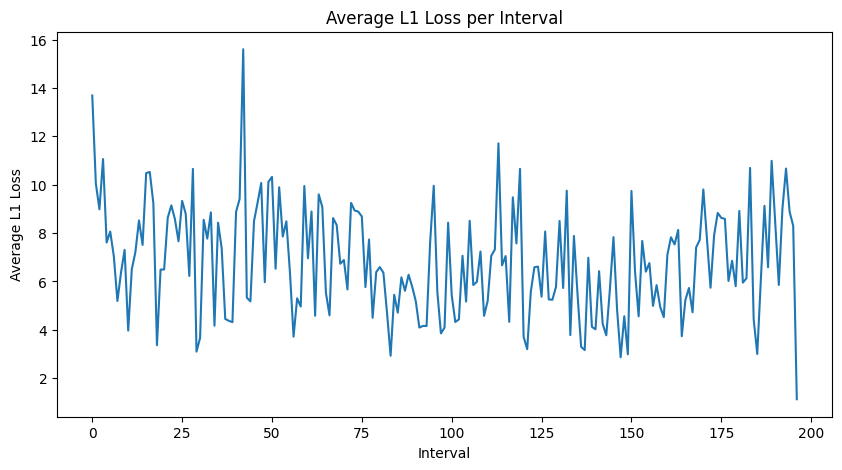

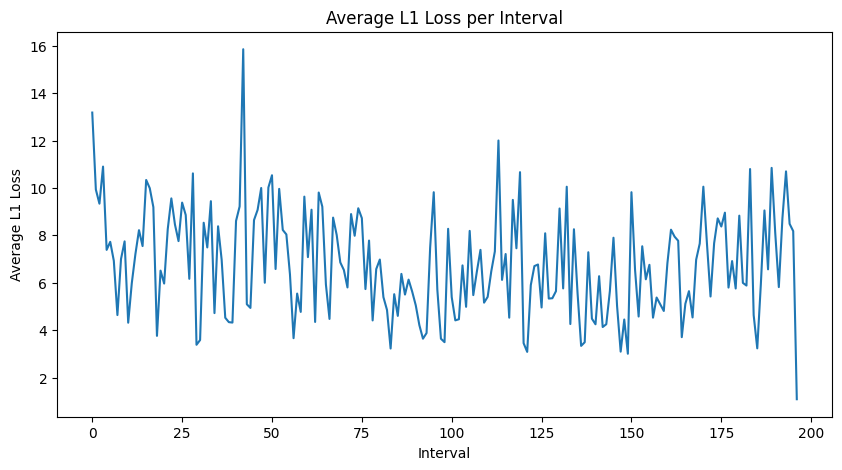

In [ ]:
test_models(models_colorbased)

In [ ]:
models_distortionbased = [
    {
      "model_purpose":"transferlearned_distortion_based_aug_VF_10epoch",
      "dataset":"utkface",
      "model_path":"transferlearned_distortion_based_aug_VF_10epoch_GAUSSIAN_utkface_resnet18_100_binary/transferlearned_distortion_based_aug_VF_10epoch_GAUSSIAN_resnet18_epoch_5_ac_65.62-57.81.pth"
    },
    {
      "model_purpose":"transferlearned_distortion_based_aug_VF_10epoch",
      "dataset":"utkface",
      "model_path":"transferlearned_distortion_based_aug_VF_10epoch_GAUSSIAN_utkface_resnet18_100_binary/transferlearned_distortion_based_aug_VF_10epoch_GAUSSIAN_resnet18_epoch_10_ac_62.50-64.06.pth"
    },

]



firstconv is 3x3
Age 0: 0
Age 1: 0
Age 2: 0
Age 3: 0
Age 4: 0
Age 5: 0
Age 6: 129
Age 7: 243
Age 8: 154
Age 9: 141
Age 10: 60
Age 11: 112
Age 12: 79
Age 13: 145
Age 14: 163
Age 15: 217
Age 16: 137
Age 17: 230
Age 18: 89
Age 19: 254
Age 20: 316
Age 21: 364
Age 22: 376
Age 23: 779
Age 24: 645
Age 25: 800
Age 26: 552
Age 27: 800
Age 28: 510
Age 29: 641
Age 30: 328
Age 31: 602
Age 32: 124
Age 33: 367
Age 34: 785
Age 35: 430
Age 36: 276
Age 37: 288
Age 38: 243
Age 39: 464
Age 40: 117
Age 41: 244
Age 42: 141
Age 43: 91
Age 44: 398
Age 45: 135
Age 46: 161
Age 47: 144
Age 48: 126
Age 49: 335
Age 50: 121
Age 51: 210
Age 52: 219
Age 53: 329
Age 54: 240
Age 55: 223
Age 56: 90
Age 57: 251
Age 58: 72
Age 59: 262
Age 60: 137
Age 61: 116
Age 62: 91
Age 63: 46
Age 64: 226
Age 65: 70
Age 66: 83
Age 67: 91
Age 68: 48
Age 69: 133
Age 70: 29
Age 71: 88
Age 72: 57
Age 73: 28
Age 74: 140
Age 75: 55
Age 76: 25
Age 77: 64
Age 78: 20
Age 79: 124
Age 80: 22
Age 81: 37
Age 82: 16
Age 83: 22
Age 84: 146
Age 85: 3

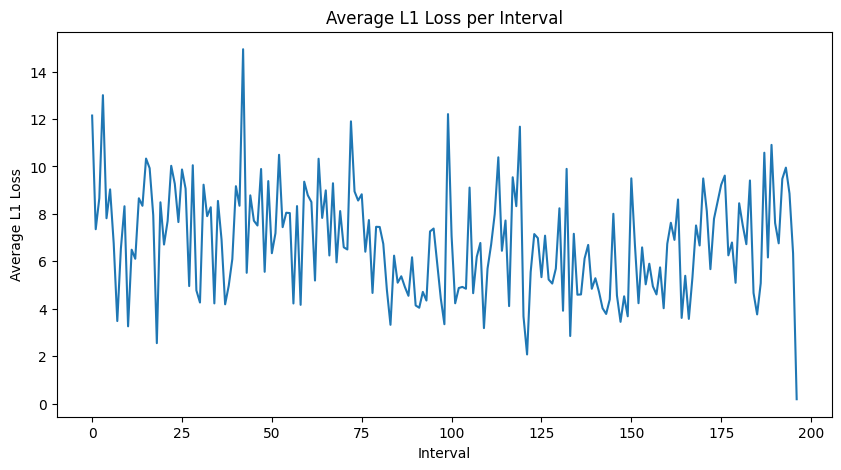

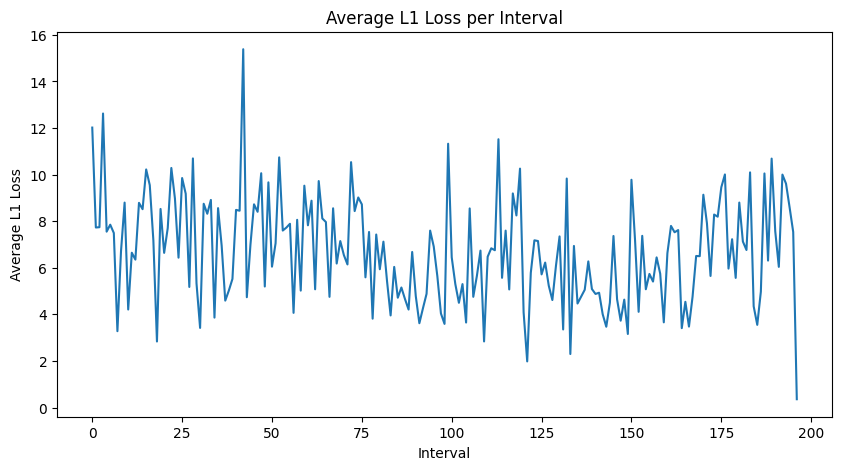

In [ ]:
test_models(models_distortionbased)

In [ ]:
models_distortioncolorbased = [
    {
      "model_purpose":"transferlearned_no_augmentation_VF_30epoch",
      "dataset":"utkface",
      "model_path":"transferlearned_distortion_color_combined_aug_VF_10epoch_GAUSSIAN_utkface_resnet18_100_binary/transferlearned_distortion_color_combined_aug_VF_10epoch_GAUSSIAN_resnet18_epoch_5_ac_65.62-64.06.pth"
    },
    {
      "model_purpose":"transferlearned_no_augmentation_VF_30epoch",
      "dataset":"utkface",
      "model_path":"transferlearned_distortion_color_combined_aug_VF_10epoch_GAUSSIAN_utkface_resnet18_100_binary/transferlearned_distortion_color_combined_aug_VF_10epoch_GAUSSIAN_resnet18_epoch_10_ac_81.25-68.75.pth"
    },

]


firstconv is 3x3
Age 0: 0
Age 1: 0
Age 2: 0
Age 3: 0
Age 4: 0
Age 5: 0
Age 6: 129
Age 7: 243
Age 8: 154
Age 9: 141
Age 10: 60
Age 11: 112
Age 12: 79
Age 13: 145
Age 14: 163
Age 15: 217
Age 16: 137
Age 17: 230
Age 18: 89
Age 19: 254
Age 20: 316
Age 21: 364
Age 22: 376
Age 23: 779
Age 24: 645
Age 25: 800
Age 26: 552
Age 27: 800
Age 28: 510
Age 29: 641
Age 30: 328
Age 31: 602
Age 32: 124
Age 33: 367
Age 34: 785
Age 35: 430
Age 36: 276
Age 37: 288
Age 38: 243
Age 39: 464
Age 40: 117
Age 41: 244
Age 42: 141
Age 43: 91
Age 44: 398
Age 45: 135
Age 46: 161
Age 47: 144
Age 48: 126
Age 49: 335
Age 50: 121
Age 51: 210
Age 52: 219
Age 53: 329
Age 54: 240
Age 55: 223
Age 56: 90
Age 57: 251
Age 58: 72
Age 59: 262
Age 60: 137
Age 61: 116
Age 62: 91
Age 63: 46
Age 64: 226
Age 65: 70
Age 66: 83
Age 67: 91
Age 68: 48
Age 69: 133
Age 70: 29
Age 71: 88
Age 72: 57
Age 73: 28
Age 74: 140
Age 75: 55
Age 76: 25
Age 77: 64
Age 78: 20
Age 79: 124
Age 80: 22
Age 81: 37
Age 82: 16
Age 83: 22
Age 84: 146
Age 85: 3

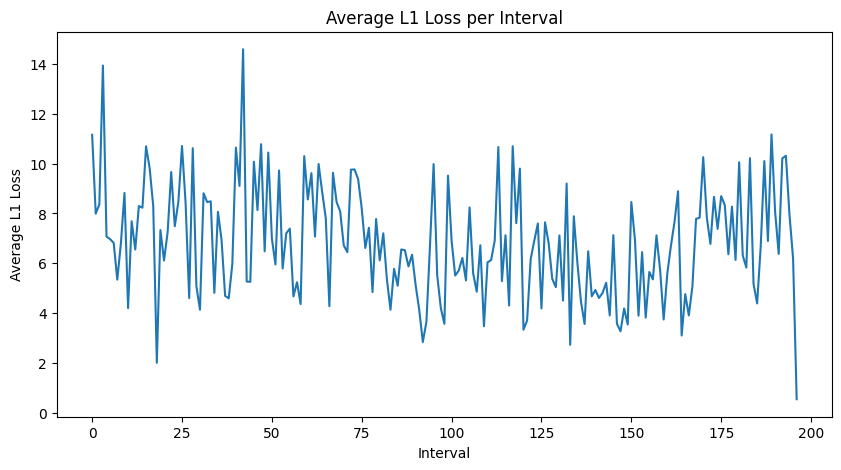

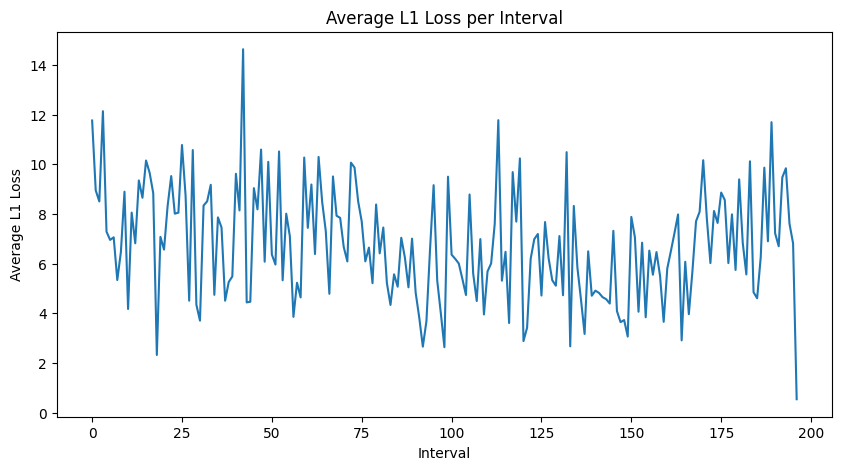

In [ ]:
test_models(models_distortioncolorbased)

In [ ]:
# For the following models go through the test pipeline
def plot_test_l1_losses(trainer,l1_losses):
    interval = 10
    avg_l1_losses = [sum(l1_losses[i:i+interval])/interval for i in range(0, len(l1_losses), interval)]
    plt.figure(figsize=(10, 5))
    plt.plot(avg_l1_losses)
    plt.title('Average L1 Loss per Interval')
    plt.xlabel('Interval')
    plt.ylabel('Average L1 Loss')
    plt.savefig(f'{trainer.save_model_dir}/test_l1_loss_{datetime.now().strftime("%m-%d_%H")}.png')

def find_file_with_epoch(directory, search_string="epoch_50"):
    """
    Search for a file in the given directory that contains the search_string in its name.

    :param directory: Directory to search in
    :param search_string: String to look for in file names
    :return: The name of the first file that contains the search_string, or None if no such file is found
    """
    for filename in os.listdir(directory):
        if search_string in filename:
            return filename
    return None

def testing_pipeline(project_dir, models, epoch_list):
    # Iterating through the models dictionary
    for dataset, augmentation_types in models.items():
        print(f"\n\n\nDataset: {dataset}")
        for augmentation, model_name in augmentation_types.items():
            print(f"\n\n  Model: {augmentation}")
            print(f"    Model Name: {model_name}")


            model_path = os.path.join(project_dir, model_name)
            for epoch in epoch_list:
                print(f"\n\nEpochs: {epoch}\n\n")
                model_file = find_file_with_epoch(model_path, f"epoch_{epoch}")

                if model_file is None:
                  print(f"Could not find model with {augmentation} epoch: {epoch}, modelfile: {model_file}")
                  continue

                config = Config()
                config.pretrained_fn = os.path.join(model_path, model_file)
                config.datanames = dataset
                config.save_model_folder()

                # start testing with test data
                trainer = DAATrainer(config)
                mae, l1_losses = trainer.test()

                # plot graphs
                plot_test_l1_losses(trainer,l1_losses)
        print()  # Adding a newline for better readability

In [ ]:
project_dir = "/content/gdrive/MyDrive/CV_DAA_PROJ/DAA_models/"
models = {
    # "megaage_asian": {
        # "No Augmentation":"no_augmentation_VF_50epoch_megaage_asian_resnet18_100_binary",
        # "Color Based Augmentation": "color_based_aug_VF_50epoch_megaage_asian_resnet18_100_binary",
        # "Distortion Based Augmentation": "distortion_based_aug_VF_TRIMMED_utkface_resnet18_100_binary",
        # "Distortion & Color Based Augmentation": "distortion_color_combined_aug_VF_50epoch_megaage_asian_resnet18_100_binary"
    # },
    "utkface": {
        # "No Augmentation":"no_augmentation_VF_TRIMMED_utkface_resnet18_100_binary",
        # "Color Based Augmentation": "color_based_aug_VF_TRIMMED_utkface_resnet18_100_binary",
        "Distortion Based Augmentation": "distortion_based_aug_TRIMMED_V2_utkface_resnet18_100_binary",
        # "Distortion & Color Based Augmentation": "distortion_color_combined_aug_VF_50epoch_utkface_resnet18_100_binary"
    }
}
epoch_list = [25,35,50]#[15,20,25,30,35,40,45,50]





Dataset: utkface


  Model: Distortion Based Augmentation
    Model Name: distortion_based_aug_TRIMMED_V2_utkface_resnet18_100_binary


Epochs: 25


firstconv is 3x3
Age 0: 0
Age 1: 0
Age 2: 0
Age 3: 0
Age 4: 0
Age 5: 0
Age 6: 129
Age 7: 243
Age 8: 154
Age 9: 141
Age 10: 60
Age 11: 112
Age 12: 79
Age 13: 145
Age 14: 163
Age 15: 217
Age 16: 137
Age 17: 230
Age 18: 89
Age 19: 254
Age 20: 316
Age 21: 364
Age 22: 376
Age 23: 450
Age 24: 450
Age 25: 450
Age 26: 450
Age 27: 450
Age 28: 450
Age 29: 450
Age 30: 328
Age 31: 450
Age 32: 124
Age 33: 367
Age 34: 450
Age 35: 430
Age 36: 276
Age 37: 288
Age 38: 243
Age 39: 450
Age 40: 117
Age 41: 244
Age 42: 141
Age 43: 91
Age 44: 398
Age 45: 135
Age 46: 161
Age 47: 144
Age 48: 126
Age 49: 335
Age 50: 121
Age 51: 210
Age 52: 219
Age 53: 329
Age 54: 240
Age 55: 223
Age 56: 90
Age 57: 251
Age 58: 72
Age 59: 262
Age 60: 137
Age 61: 116
Age 62: 91
Age 63: 46
Age 64: 226
Age 65: 70
Age 66: 83
Age 67: 91
Age 68: 48
Age 69: 133
Age 70: 29
Age 71: 88
Age

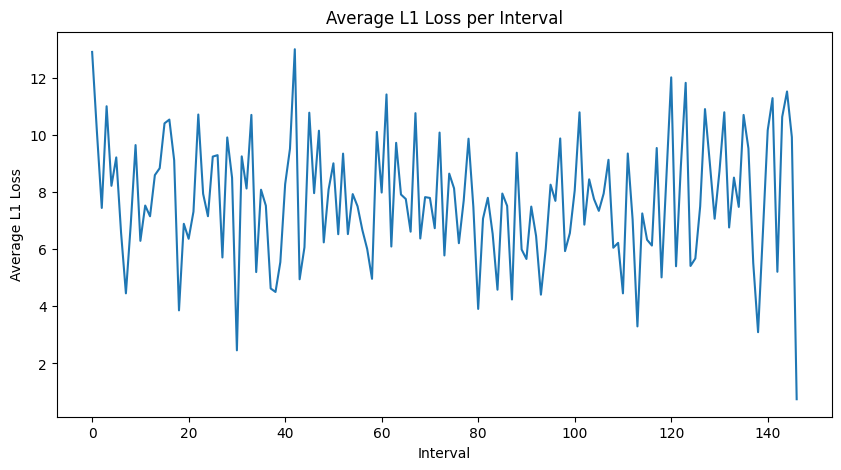

In [ ]:
#utkface dataset: distortion trimmed v2
testing_pipeline(project_dir, models, epoch_list)




Dataset: megaage_asian


  Model: Distortion Based Augmentation
    Model Name: distortion_based_aug_VF_TRIMMED_utkface_resnet18_100_binary


Epochs: 50


firstconv is 3x3
Age 0: 0
Age 1: 0
Age 2: 0
Age 3: 0
Age 4: 0
Age 5: 0
Age 6: 306
Age 7: 295
Age 8: 272
Age 9: 326
Age 10: 324
Age 11: 500
Age 12: 302
Age 13: 377
Age 14: 571
Age 15: 543
Age 16: 573
Age 17: 638
Age 18: 628
Age 19: 949
Age 20: 858
Age 21: 851
Age 22: 1031
Age 23: 1227
Age 24: 710
Age 25: 889
Age 26: 1253
Age 27: 1584
Age 28: 899
Age 29: 968
Age 30: 558
Age 31: 534
Age 32: 629
Age 33: 596
Age 34: 748
Age 35: 656
Age 36: 987
Age 37: 1025
Age 38: 787
Age 39: 734
Age 40: 527
Age 41: 623
Age 42: 730
Age 43: 886
Age 44: 430
Age 45: 640
Age 46: 643
Age 47: 452
Age 48: 548
Age 49: 288
Age 50: 559
Age 51: 1054
Age 52: 333
Age 53: 328
Age 54: 450
Age 55: 504
Age 56: 429
Age 57: 297
Age 58: 163
Age 59: 284
Age 60: 240
Age 61: 157
Age 62: 106
Age 63: 204
Age 64: 224
Age 65: 245
Age 66: 268
Age 67: 195
Age 68: 176
Age 69: 0
Age

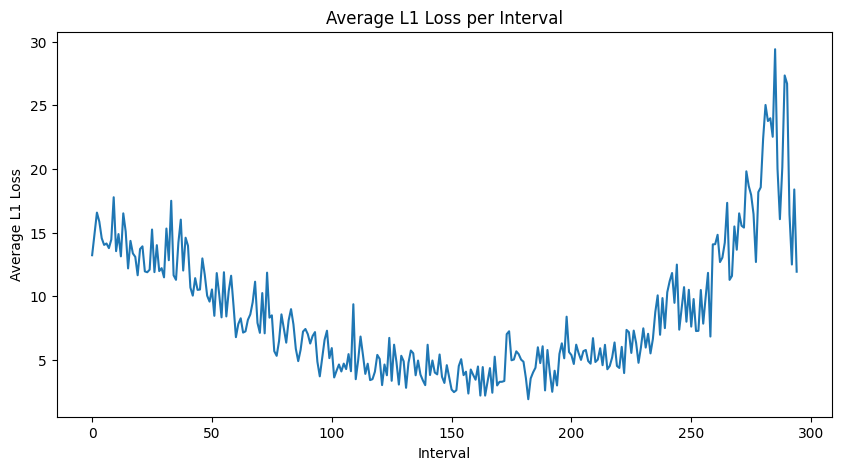

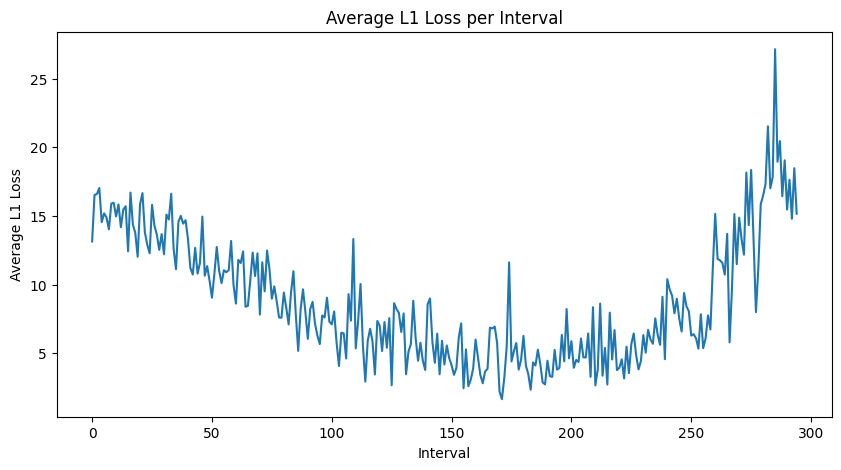

In [ ]:
#utkface dataset: but distortion megaage asian model
testing_pipeline(project_dir, models, epoch_list)




Dataset: utkface


  Model: Distortion Based Augmentation
    Model Name: distortion_based_aug_VF_50epoch_megaage_asian_resnet18_100_binary


Epochs: 50


firstconv is 3x3
Age 0: 0
Age 1: 0
Age 2: 0
Age 3: 0
Age 4: 0
Age 5: 0
Age 6: 129
Age 7: 243
Age 8: 154
Age 9: 141
Age 10: 60
Age 11: 112
Age 12: 79
Age 13: 145
Age 14: 163
Age 15: 217
Age 16: 137
Age 17: 230
Age 18: 89
Age 19: 254
Age 20: 316
Age 21: 364
Age 22: 376
Age 23: 779
Age 24: 645
Age 25: 1983
Age 26: 552
Age 27: 845
Age 28: 510
Age 29: 641
Age 30: 328
Age 31: 602
Age 32: 124
Age 33: 367
Age 34: 785
Age 35: 430
Age 36: 276
Age 37: 288
Age 38: 243
Age 39: 464
Age 40: 117
Age 41: 244
Age 42: 141
Age 43: 91
Age 44: 398
Age 45: 135
Age 46: 161
Age 47: 144
Age 48: 126
Age 49: 335
Age 50: 121
Age 51: 210
Age 52: 219
Age 53: 329
Age 54: 240
Age 55: 223
Age 56: 90
Age 57: 251
Age 58: 72
Age 59: 262
Age 60: 137
Age 61: 116
Age 62: 91
Age 63: 46
Age 64: 226
Age 65: 70
Age 66: 83
Age 67: 91
Age 68: 48
Age 69: 133
Age 70: 29
Age 71:

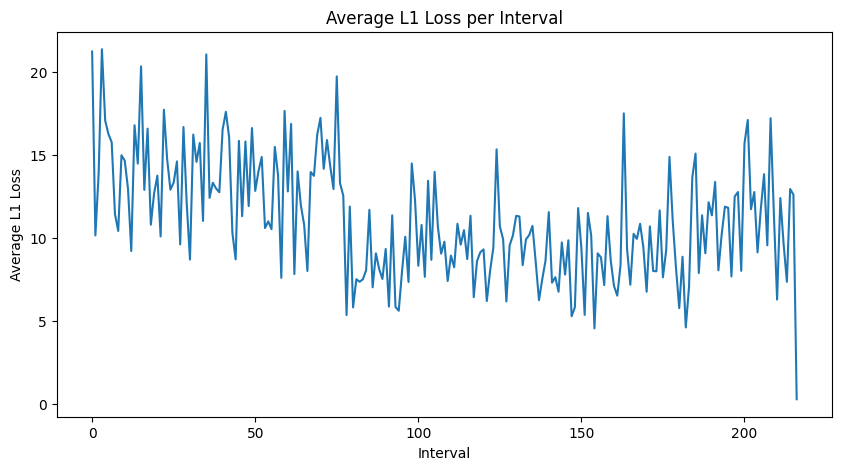

In [ ]:
#utkface dataset: but distortion megaage asian model
testing_pipeline(project_dir, models, epoch_list)




Dataset: utkface


  Model: No Augmentation
    Model Name: no_augmentation_VF_TRIMMED_utkface_resnet18_100_binary


Epochs: 200


firstconv is 3x3
Age 0: 0
Age 1: 0
Age 2: 0
Age 3: 0
Age 4: 0
Age 5: 0
Age 6: 129
Age 7: 243
Age 8: 154
Age 9: 141
Age 10: 60
Age 11: 112
Age 12: 79
Age 13: 145
Age 14: 163
Age 15: 217
Age 16: 137
Age 17: 230
Age 18: 89
Age 19: 254
Age 20: 316
Age 21: 364
Age 22: 376
Age 23: 779
Age 24: 645
Age 25: 1983
Age 26: 552
Age 27: 845
Age 28: 510
Age 29: 641
Age 30: 328
Age 31: 602
Age 32: 124
Age 33: 367
Age 34: 785
Age 35: 430
Age 36: 276
Age 37: 288
Age 38: 243
Age 39: 464
Age 40: 117
Age 41: 244
Age 42: 141
Age 43: 91
Age 44: 398
Age 45: 135
Age 46: 161
Age 47: 144
Age 48: 126
Age 49: 335
Age 50: 121
Age 51: 210
Age 52: 219
Age 53: 329
Age 54: 240
Age 55: 223
Age 56: 90
Age 57: 251
Age 58: 72
Age 59: 262
Age 60: 137
Age 61: 116
Age 62: 91
Age 63: 46
Age 64: 226
Age 65: 70
Age 66: 83
Age 67: 91
Age 68: 48
Age 69: 133
Age 70: 29
Age 71: 88
Age 72: 57
Age 73: 2

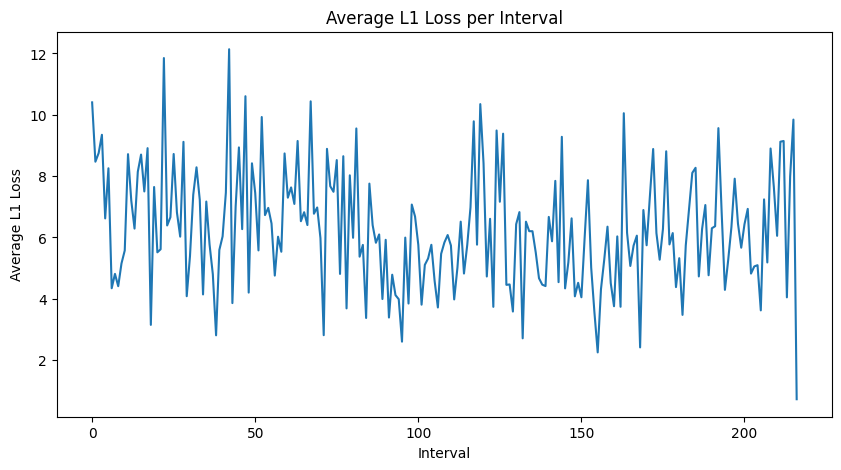

In [ ]:
#no_augmentation_VF_TRIMMED_utkface_resnet18_100_binary
testing_pipeline(project_dir, models, epoch_list)




Dataset: utkface


  Model: Color Based Augmentation
    Model Name: color_based_aug_VF_TRIMMED_utkface_resnet18_100_binary


Epochs: 15


firstconv is 3x3
Age 0: 0
Age 1: 0
Age 2: 0
Age 3: 0
Age 4: 0
Age 5: 0
Age 6: 129
Age 7: 243
Age 8: 154
Age 9: 141
Age 10: 60
Age 11: 112
Age 12: 79
Age 13: 145
Age 14: 163
Age 15: 217
Age 16: 137
Age 17: 230
Age 18: 89
Age 19: 254
Age 20: 316
Age 21: 364
Age 22: 376
Age 23: 779
Age 24: 645
Age 25: 1983
Age 26: 552
Age 27: 845
Age 28: 510
Age 29: 641
Age 30: 328
Age 31: 602
Age 32: 124
Age 33: 367
Age 34: 785
Age 35: 430
Age 36: 276
Age 37: 288
Age 38: 243
Age 39: 464
Age 40: 117
Age 41: 244
Age 42: 141
Age 43: 91
Age 44: 398
Age 45: 135
Age 46: 161
Age 47: 144
Age 48: 126
Age 49: 335
Age 50: 121
Age 51: 210
Age 52: 219
Age 53: 329
Age 54: 240
Age 55: 223
Age 56: 90
Age 57: 251
Age 58: 72
Age 59: 262
Age 60: 137
Age 61: 116
Age 62: 91
Age 63: 46
Age 64: 226
Age 65: 70
Age 66: 83
Age 67: 91
Age 68: 48
Age 69: 133
Age 70: 29
Age 71: 88
Age 72: 57
A

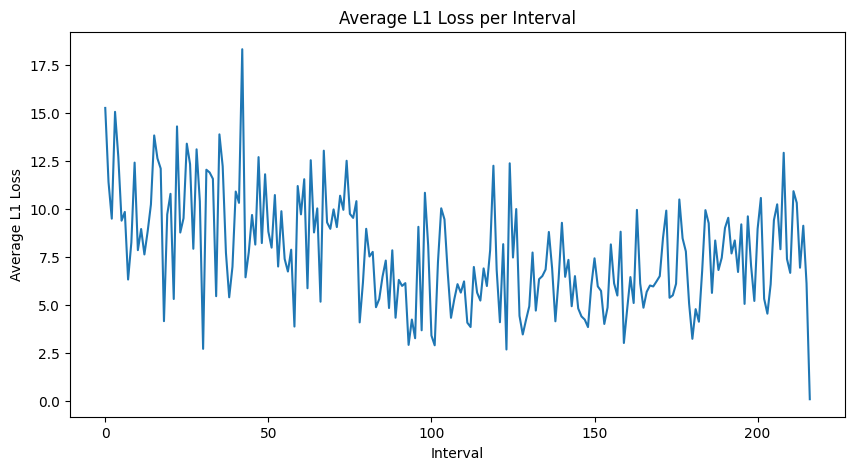

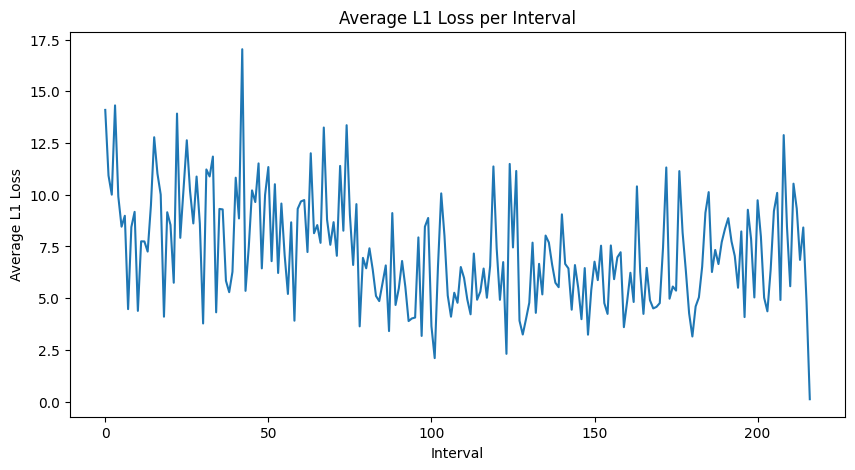

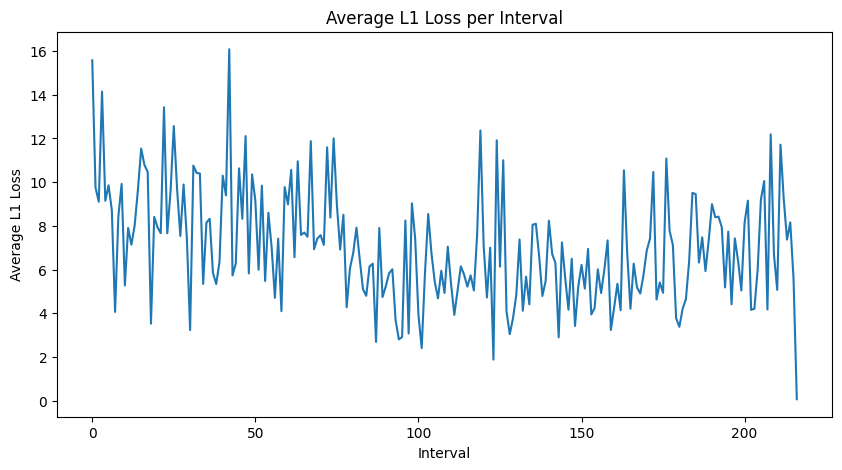

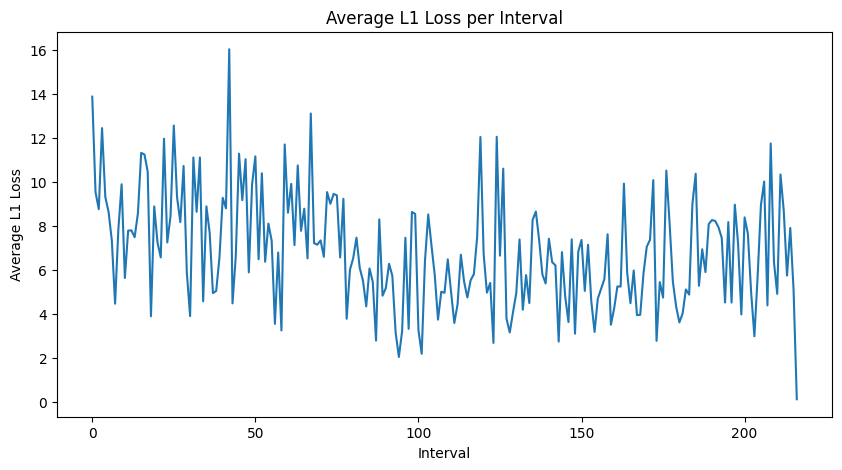

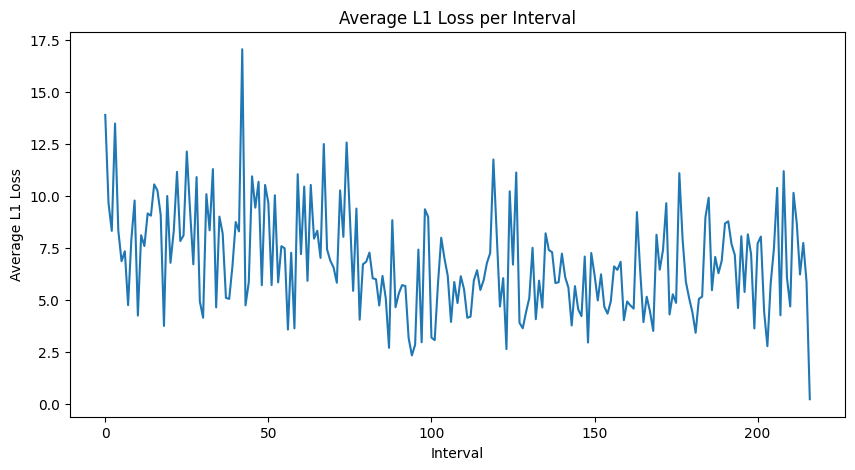

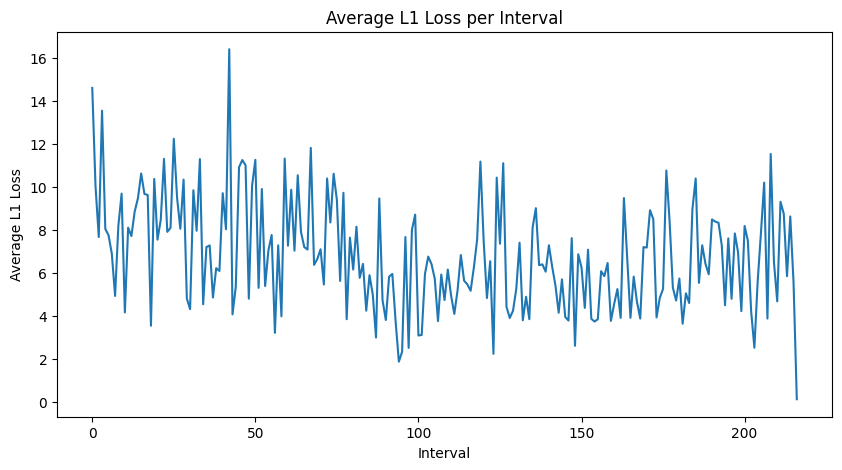

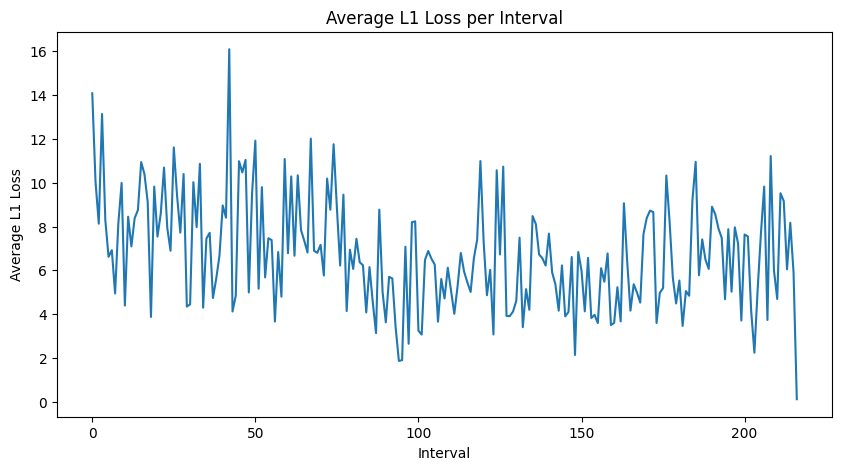

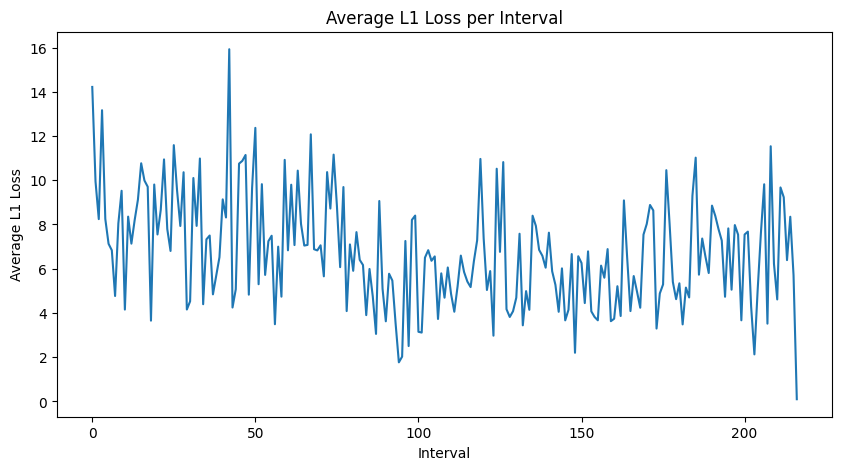

In [ ]:
# color_based_aug_VF_TRIMMED_utkface_resnet18_100_binary
testing_pipeline(project_dir, models, epoch_list)




Dataset: utkface


  Model: Distortion & Color Based Augmentation
    Model Name: distortion_color_combined_aug_VF_50epoch_utkface_resnet18_100_binary


Epochs: 15


firstconv is 3x3
Age 0: 0
Age 1: 0
Age 2: 0
Age 3: 0
Age 4: 0
Age 5: 0
Age 6: 129
Age 7: 243
Age 8: 154
Age 9: 141
Age 10: 60
Age 11: 112
Age 12: 79
Age 13: 145
Age 14: 163
Age 15: 217
Age 16: 137
Age 17: 230
Age 18: 89
Age 19: 254
Age 20: 316
Age 21: 364
Age 22: 376
Age 23: 779
Age 24: 645
Age 25: 1983
Age 26: 552
Age 27: 845
Age 28: 510
Age 29: 641
Age 30: 328
Age 31: 602
Age 32: 124
Age 33: 367
Age 34: 785
Age 35: 430
Age 36: 276
Age 37: 288
Age 38: 243
Age 39: 464
Age 40: 117
Age 41: 244
Age 42: 141
Age 43: 91
Age 44: 398
Age 45: 135
Age 46: 161
Age 47: 144
Age 48: 126
Age 49: 335
Age 50: 121
Age 51: 210
Age 52: 219
Age 53: 329
Age 54: 240
Age 55: 223
Age 56: 90
Age 57: 251
Age 58: 72
Age 59: 262
Age 60: 137
Age 61: 116
Age 62: 91
Age 63: 46
Age 64: 226
Age 65: 70
Age 66: 83
Age 67: 91
Age 68: 48
Age 69: 133
Age 70:

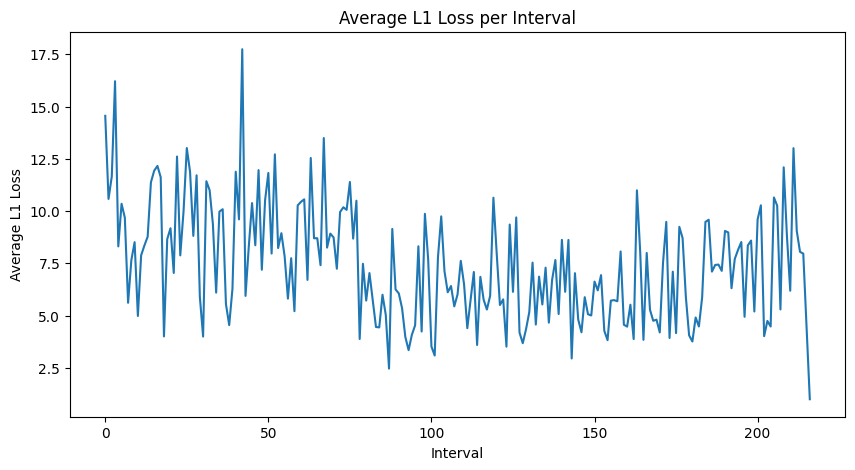

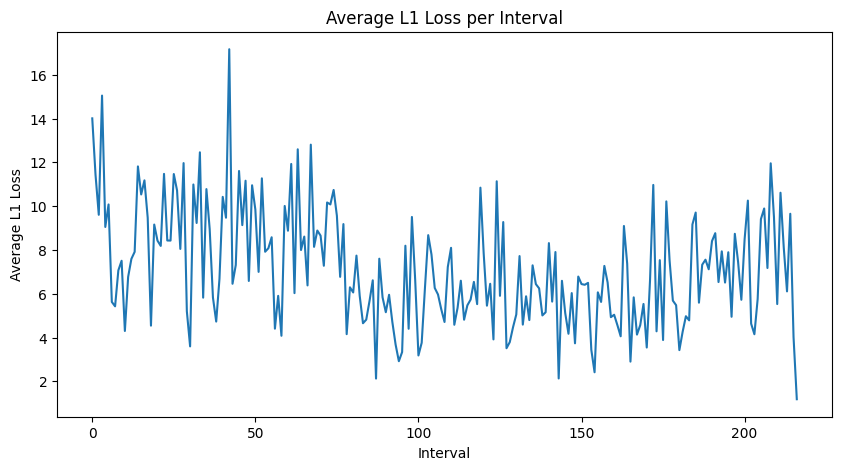

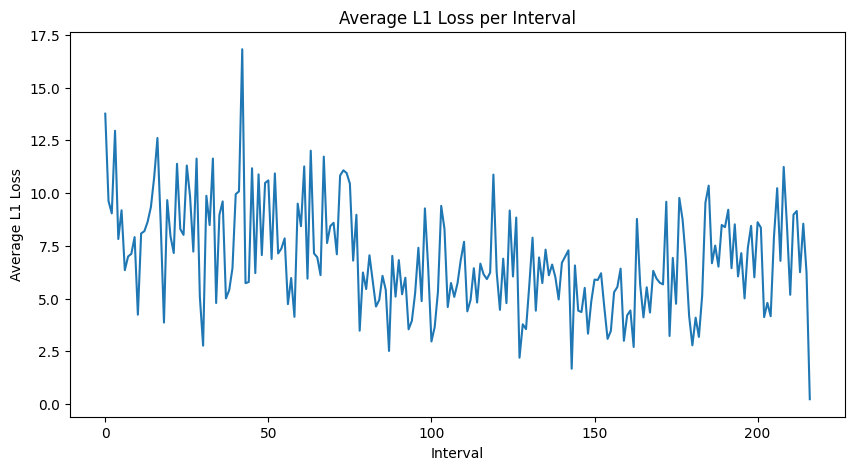

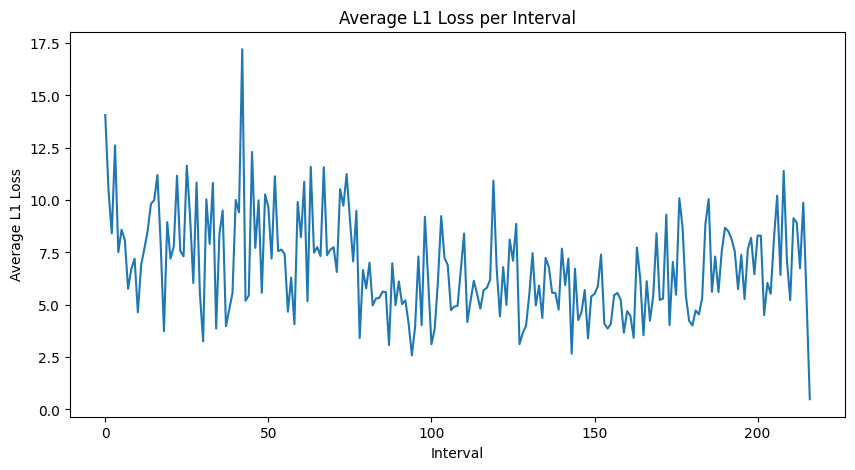

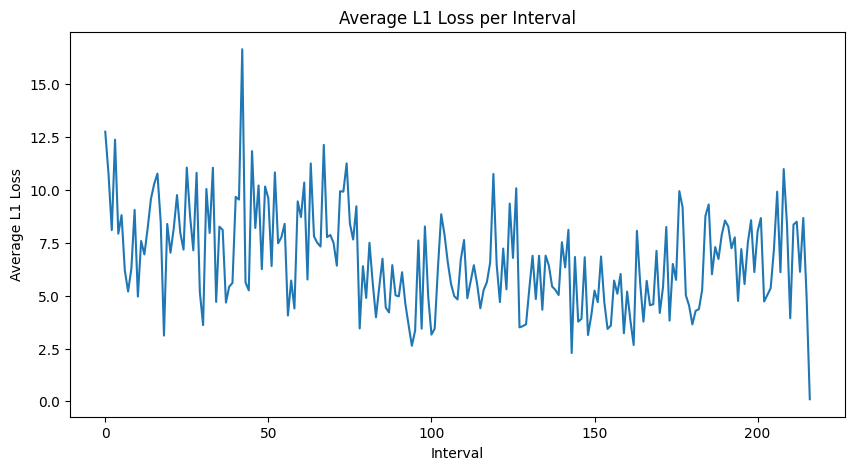

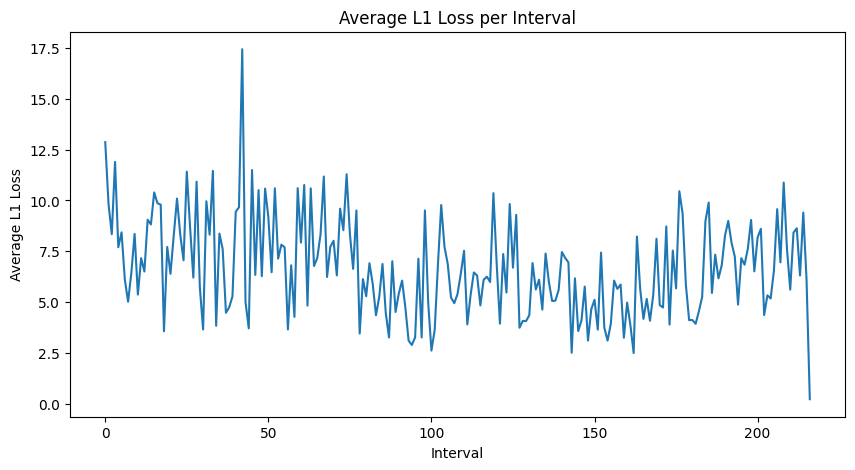

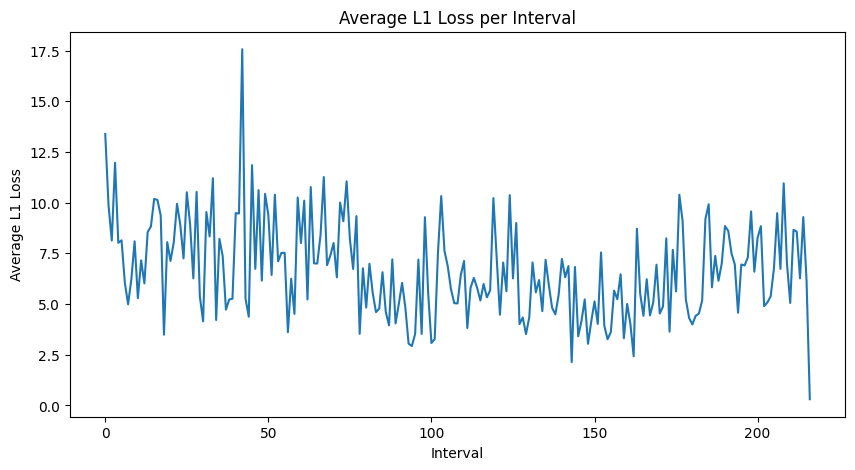

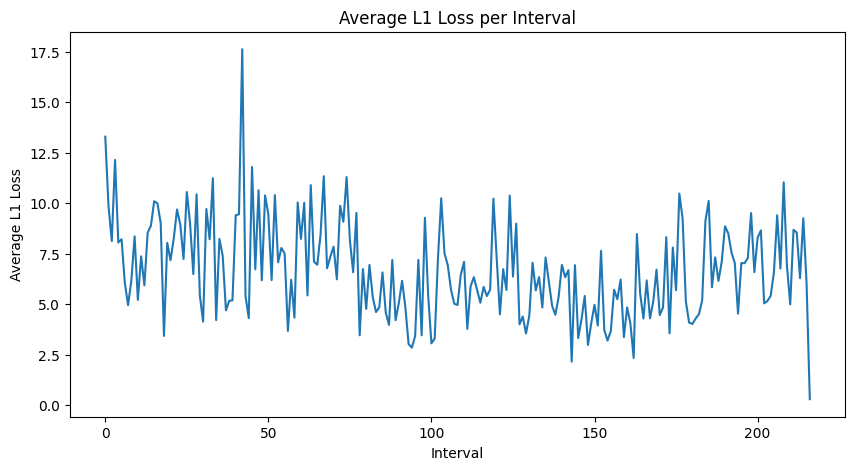

In [ ]:
#distortion_color_combined_aug_VF_50epoch_utkface_resnet18_100_binary
testing_pipeline(project_dir, models, epoch_list)




Dataset: utkface


  Model: No Augmentation
    Model Name: no_augmentation_VF_TRIMMED_utkface_resnet18_100_binary


Epochs: 15


firstconv is 3x3
Age 0: 0
Age 1: 0
Age 2: 0
Age 3: 0
Age 4: 0
Age 5: 0
Age 6: 129
Age 7: 243
Age 8: 154
Age 9: 141
Age 10: 60
Age 11: 112
Age 12: 79
Age 13: 145
Age 14: 163
Age 15: 217
Age 16: 137
Age 17: 230
Age 18: 89
Age 19: 254
Age 20: 316
Age 21: 364
Age 22: 376
Age 23: 779
Age 24: 645
Age 25: 1983
Age 26: 552
Age 27: 845
Age 28: 510
Age 29: 641
Age 30: 328
Age 31: 602
Age 32: 124
Age 33: 367
Age 34: 785
Age 35: 430
Age 36: 276
Age 37: 288
Age 38: 243
Age 39: 464
Age 40: 117
Age 41: 244
Age 42: 141
Age 43: 91
Age 44: 398
Age 45: 135
Age 46: 161
Age 47: 144
Age 48: 126
Age 49: 335
Age 50: 121
Age 51: 210
Age 52: 219
Age 53: 329
Age 54: 240
Age 55: 223
Age 56: 90
Age 57: 251
Age 58: 72
Age 59: 262
Age 60: 137
Age 61: 116
Age 62: 91
Age 63: 46
Age 64: 226
Age 65: 70
Age 66: 83
Age 67: 91
Age 68: 48
Age 69: 133
Age 70: 29
Age 71: 88
Age 72: 57
Age 73: 28

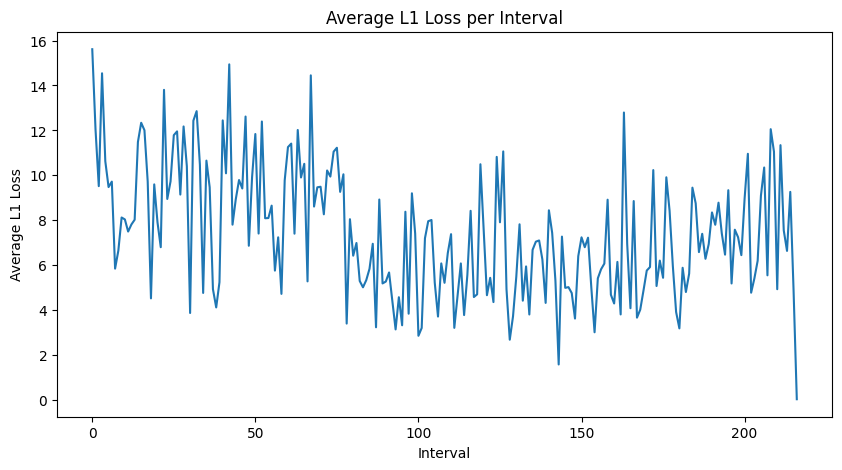

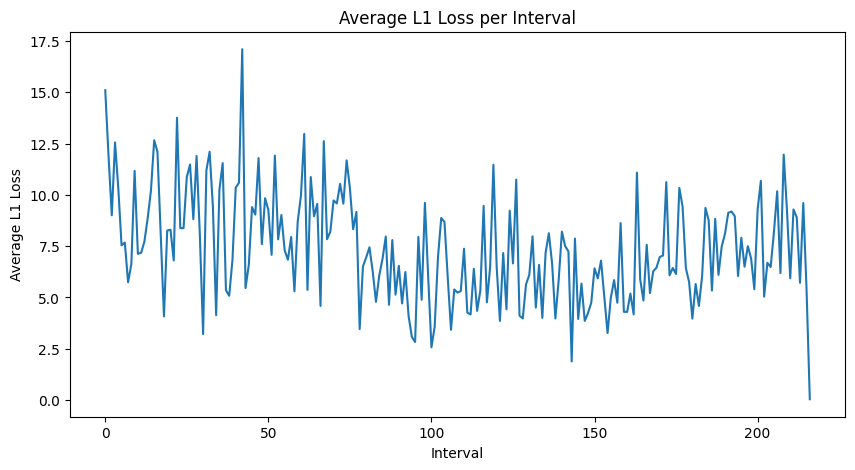

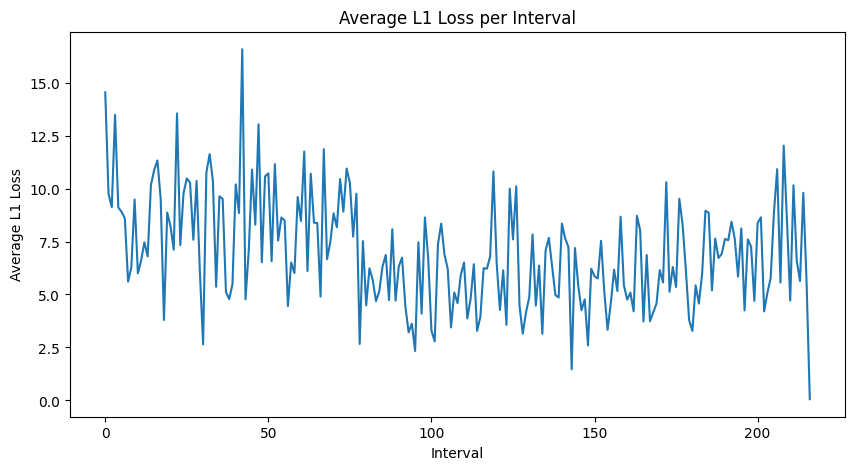

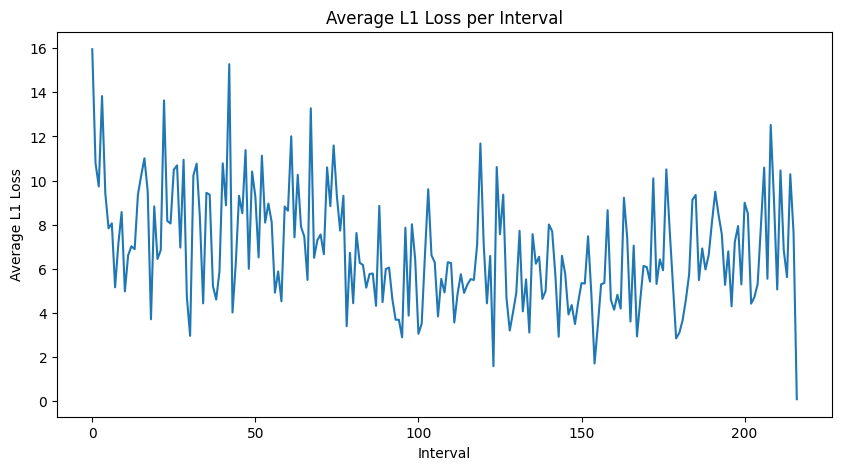

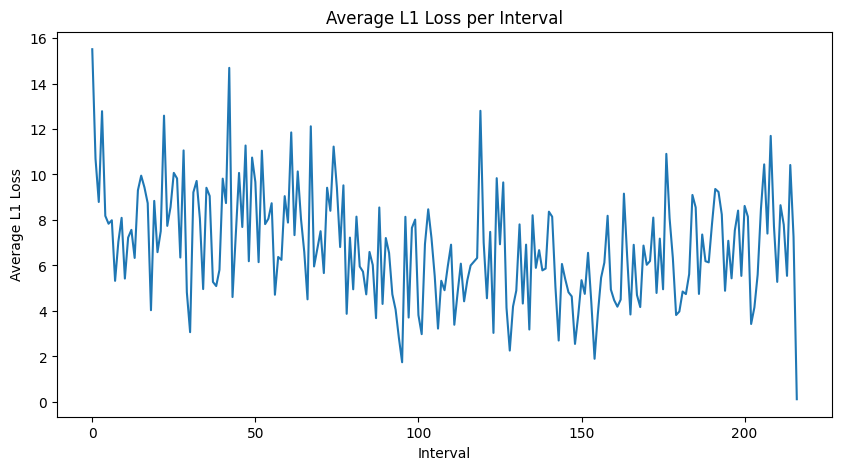

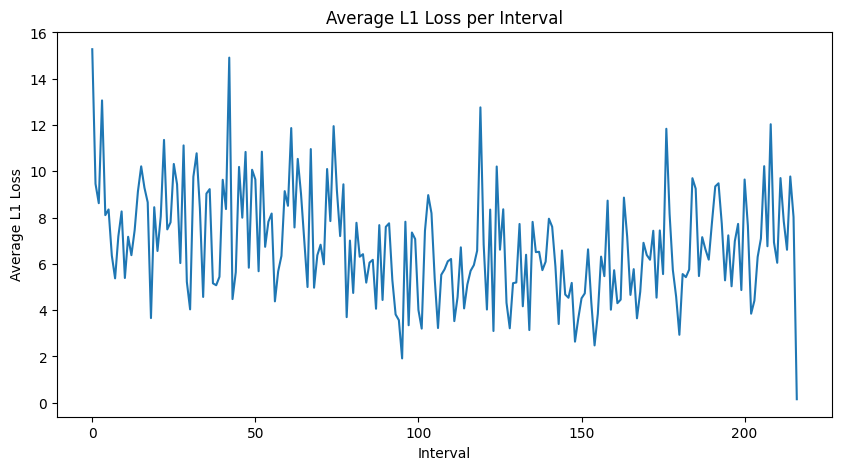

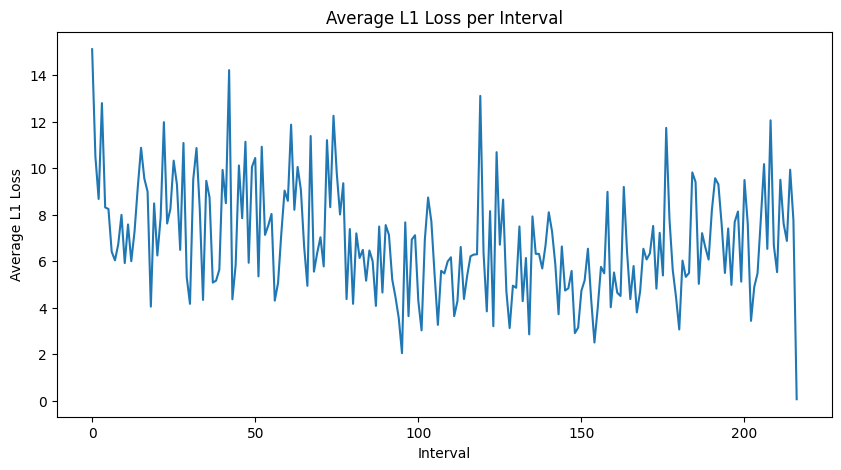

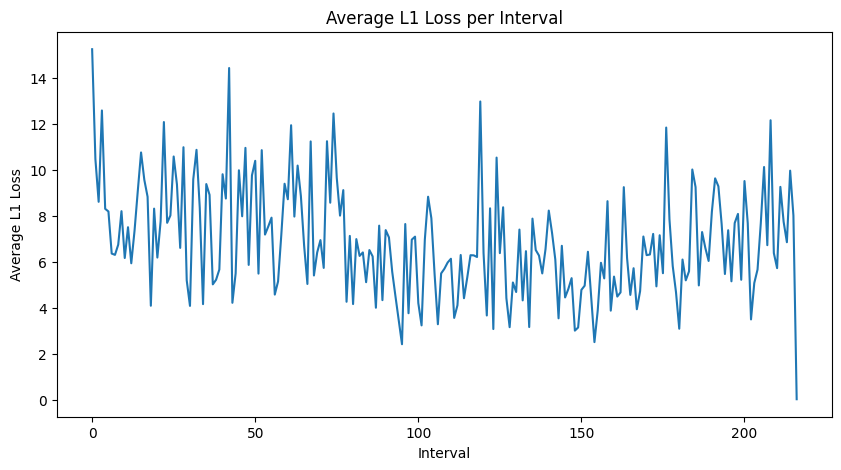

In [ ]:
testing_pipeline(project_dir, models, epoch_list)




Dataset: utkface


  Model: Distortion Based Augmentation
    Model Name: distortion_based_aug_VF_TRIMMED_utkface_resnet18_100_binary


Epochs: 145


firstconv is 3x3
Age 0: 0
Age 1: 0
Age 2: 0
Age 3: 0
Age 4: 0
Age 5: 0
Age 6: 129
Age 7: 243
Age 8: 154
Age 9: 141
Age 10: 60
Age 11: 112
Age 12: 79
Age 13: 145
Age 14: 163
Age 15: 217
Age 16: 137
Age 17: 230
Age 18: 89
Age 19: 254
Age 20: 316
Age 21: 364
Age 22: 376
Age 23: 779
Age 24: 645
Age 25: 1983
Age 26: 552
Age 27: 845
Age 28: 510
Age 29: 641
Age 30: 328
Age 31: 602
Age 32: 124
Age 33: 367
Age 34: 785
Age 35: 430
Age 36: 276
Age 37: 288
Age 38: 243
Age 39: 464
Age 40: 117
Age 41: 244
Age 42: 141
Age 43: 91
Age 44: 398
Age 45: 135
Age 46: 161
Age 47: 144
Age 48: 126
Age 49: 335
Age 50: 121
Age 51: 210
Age 52: 219
Age 53: 329
Age 54: 240
Age 55: 223
Age 56: 90
Age 57: 251
Age 58: 72
Age 59: 262
Age 60: 137
Age 61: 116
Age 62: 91
Age 63: 46
Age 64: 226
Age 65: 70
Age 66: 83
Age 67: 91
Age 68: 48
Age 69: 133
Age 70: 29
Age 71: 88
A

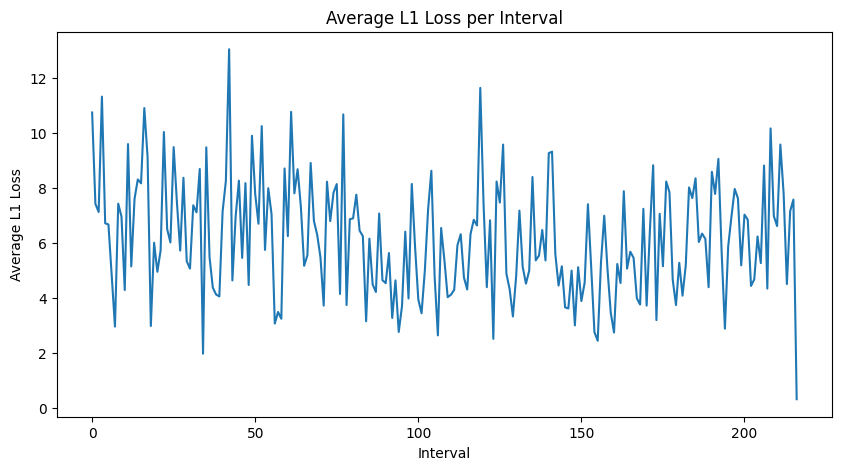

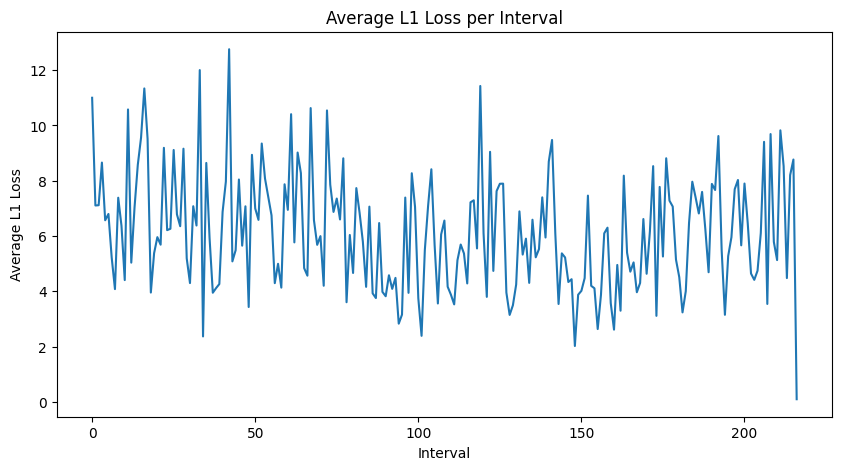

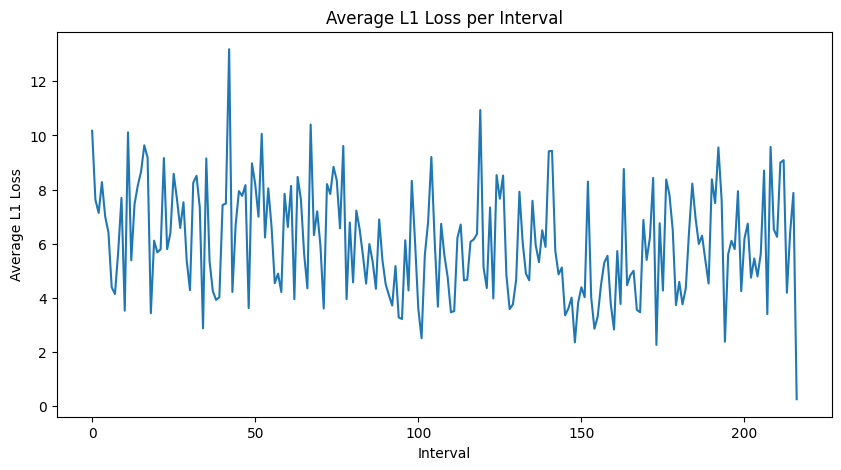

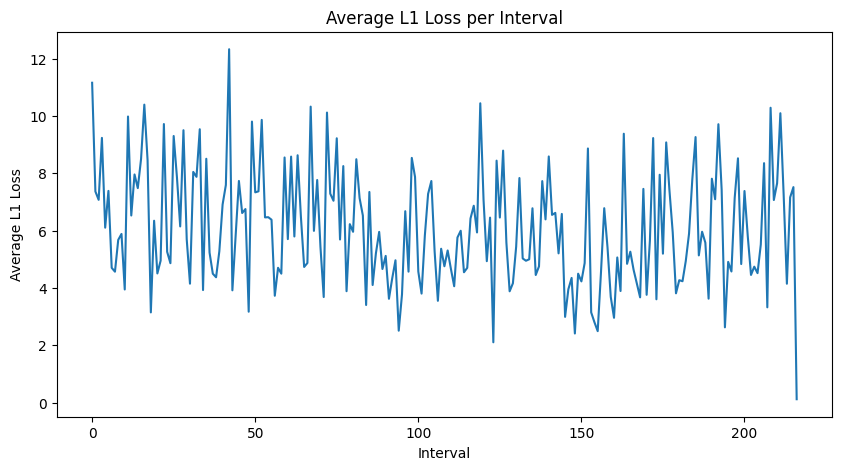

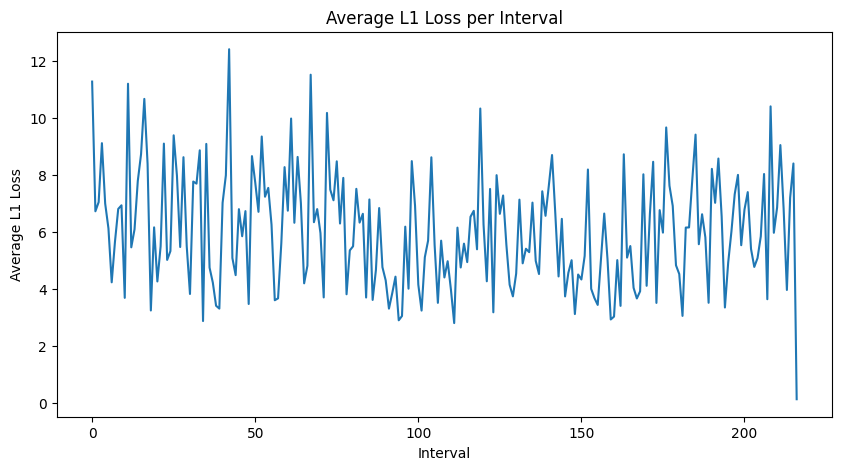

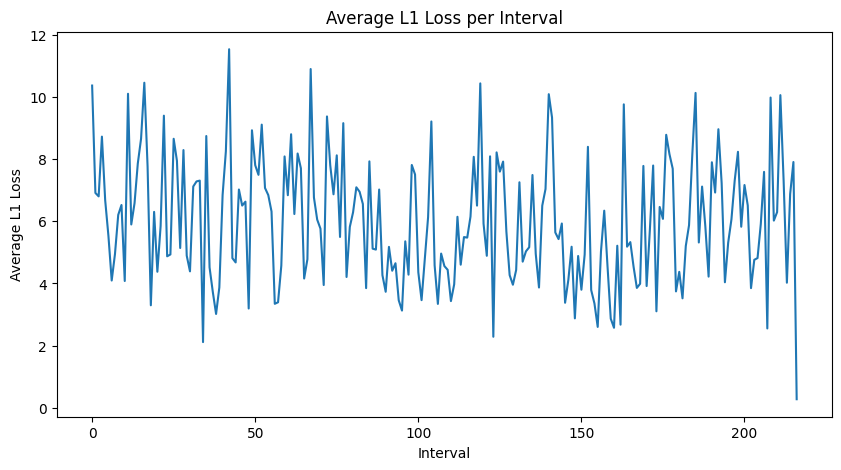

In [ ]:
  #Distortion Based Augmentation
testing_pipeline(project_dir, models, epoch_list)